# 7 ML-ENSO - CNN Multi-task Regression (E and C indices)

In [1]:
print("hello world")

hello world


### Imports 

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Using device: cuda

NVIDIA A40


In [4]:
import utils

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MultipleLocator

import os
import pandas as pd
import xarray as xr
import calendar

from datetime import datetime

import sklearn
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import scipy.stats

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import pickle

from tqdm import tqdm

### Define folders

In [6]:
CMIP6_ANOM_1M_FOLDER = 'datasets/CMIP6/CMIP6_regridded/anom_1m'
CMIP6_ONI_FOLDER = 'datasets/CMIP6/CMIP6_regridded/oni'
CMIP6_NINO34_FOLDER = 'datasets/CMIP6/CMIP6_regridded/nino34'
CMIP6_EC_FOLDER = 'datasets/CMIP6/CMIP6_regridded/ec_indices'

HadISST_ANOM_1M_FOLDER = 'datasets/HadISST/HadISST_regridded/anom_1m'
HadISST_ONI_FOLDER = 'datasets/HadISST/HadISST_regridded/oni'
HadISST_NINO34_FOLDER = 'datasets/HadISST/HadISST_regridded/nino34'
HadISST_EC_FOLDER = 'datasets/HadISST/HadISST_regridded/ec_indices'

MODELS_ONI_FOLDER = 'saved_models/oni'
MODELS_NINO34_FOLDER = 'saved_models/nino34'
MODELS_EC_FOLDER = 'saved_models/ec'

RESULTS_FOLDER = 'saved_results'
RESULTS_ONI_FOLDER = 'saved_results/oni'
RESULTS_NINO34_FOLDER = 'saved_results/nino34'
RESULTS_EC_FOLDER = 'saved_results/ec'

RESULTS_EC_PF_FOLDER = os.path.join(RESULTS_EC_FOLDER, "persistent_forecast")
RESULTS_EC_LR_FOLDER = os.path.join(RESULTS_EC_FOLDER, "linear_regression")
RESULTS_EC_RR_FOLDER = os.path.join(RESULTS_EC_FOLDER, "ridge_regression")
RESULTS_EC_CNN_FOLDER = os.path.join(RESULTS_EC_FOLDER, "cnn")
os.makedirs(RESULTS_EC_CNN_FOLDER, exist_ok=True) 


IMG_FOLDER = 'img/'
SAVE_PLOTS_TO_DISK = True

In [7]:
os.makedirs(MODELS_EC_FOLDER, exist_ok=True) 

### Global variables

In [8]:
GENERAL_MODE = "training"
# GENERAL_MODE = "view_results_only"

In [9]:
INPUT_TIME_STEPS = 3
NUM_EPOCHS = 40
MAX_LEAD_TIME = 12
TARGETS = ["E", "C"] # ["oni", "nino34"]
# TARGETS = ["E_index", "C_index"] # ["oni", "nino34"]
mode = "training" # "testing"

# Adam optimizer parameters
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0 # 1e-3

# SGD optimizer parameters
# LEARNING_RATE = 1e-4
# MOMENTUM = 0.9


ROLLING_AMOUNT = 3

### Select training region

In [10]:
FULL_MAP = False

if FULL_MAP == True:
    # Full map
    MIN_LAT, MAX_LAT = -90, +90
    MIN_LON, MAX_LON = 0, 360
    LAT_SLICE = None
    LON_SLICE = None
else:
    # Ham et. al: 0°–360°E, 55°S–60°N for three consecutive months 
    MIN_LAT, MAX_LAT = -55, 60
    MIN_LON, MAX_LON = 0, 360
    
    LAT_SLICE = slice(MIN_LAT, MAX_LAT)
    LON_SLICE = slice(MIN_LON, MAX_LON) 

    # Tello et. al: 0°–360°E, 75°S–65°N for three consecutive months 
    # MIN_LAT, MAX_LAT = -75, 65
    # MIN_LON, MAX_LON = 0, 360
    
    # LAT_SLICE = slice(MIN_LAT, MAX_LAT)
    # LON_SLICE = slice(MIN_LON, MAX_LON) 


# Niño 3.4 (5N-5S, 170W-120W)
# nino34_min_lat, nino34_max_lat = -5, 5
# nino34_min_lon, nino34_max_lon = 190, 240


In [11]:
coordinates = utils.add_cardinals_title(MIN_LAT, MAX_LAT, MIN_LON, MAX_LON)
coordinates

'55S-60N, 180W-180E'

### Select dataset source 

In [12]:
# source_id = "MRI-ESM2-0"
# source_id = "MIROC6"
# source_id = "BCC-ESM1"
source_id = "GISS-E2-1-G"

### Split Train / Val / Test sets longitudinally
Randomly splitting time series data into a train set and a test set is very risky. \
In many climate datasets, time series have a non-neglible auto-correlation (correlation of a time series and its lagged version over time). \
Think of it like this: the atmosphere usually has a "memory" of about 14 days, and the ocean roughly has a "memory" of about 2 years.

_(source: [CCAI Seasonal Forecasting tutorial](https://colab.research.google.com/drive/1eLEYFK3Mrae_nu1SzAjg7Sdf40bWnKTg#scrollTo=XrbMcDoscZM0&forceEdit=true&sandboxMode=true))_

In [13]:
train_start_date = '1851-01-01'
train_end_date = '1970-12-31'

val_start_date = '1976-01-01'
val_end_date =   '1990-12-31'

test_start_date = '1996-01-01'
test_end_date =   '2010-12-31'

print(f"Train start and end dates: {train_start_date} to {train_end_date}")
print(f"Val start and end dates: {val_start_date} to {val_end_date}")
print(f"Test start and end dates: {test_start_date} to {test_end_date}")

Train start and end dates: 1851-01-01 to 1970-12-31
Val start and end dates: 1976-01-01 to 1990-12-31
Test start and end dates: 1996-01-01 to 2010-12-31


In [14]:
# extract year part of the dates
train_start_year = train_start_date.split("-")[0]
train_end_year   = train_end_date.split("-")[0]

val_start_year = val_start_date.split("-")[0]
val_end_year   = val_end_date.split("-")[0]

test_start_year = test_start_date.split("-")[0]
test_end_year   = test_end_date.split("-")[0]

print(f"Train start and end years: {train_start_year}-{train_end_year}")
print(f"Train start and end years: {val_start_year}-{val_end_year}")
print(f"Train start and end years: {test_start_year}-{test_end_year}")

Train start and end years: 1851-1970
Train start and end years: 1976-1990
Train start and end years: 1996-2010


In [15]:
cnn_subtitle = (f'Training on {source_id} SST anomalies in region {coordinates} from {train_start_year} to {train_end_year}. Evaluation between {test_start_year} and {test_end_year}\n'
            f'CNN Parameters: input steps={INPUT_TIME_STEPS} month(s), optimizer: Adam, learning rate={LEARNING_RATE}')
print(cnn_subtitle)

Training on GISS-E2-1-G SST anomalies in region 55S-60N, 180W-180E from 1851 to 1970. Evaluation between 1996 and 2010
CNN Parameters: input steps=3 month(s), optimizer: Adam, learning rate=0.0001


## Define functions

#### `find_file`

In [16]:
def find_file(directory, source_id):
    filenames = os.listdir(directory)

    # Iterate over files int the directory and return the first match
    for filename in filenames:
        if source_id in filename:
            filepath = os.path.join(directory, filename)
            return filename, filepath
    print(f"No file with source id {source_id} was found")
    return None 

#### `plot_nino_time_series`

In [17]:
def plot_nino_time_series(y, predictions, source_id, title):
    """
    inputs
    ------
        y           pd.Series : time series of the true Nino index
        predictions np.array  : time series of the predicted Nino index (same
                                length and time as y)
        titile                : the title of the plot

    outputs
    -------
        None.  Displays the plot
    """
    predictions = pd.Series(predictions, index=y.index)
    predictions = predictions.sort_index()
    y = y.sort_index()
    
    plt.figure(figsize=(6,1))  # Set the size of the figure
    
    plt.plot(y, label=f'GT ({source_id})')
    plt.plot(predictions, '--', label='ML Predictions')
    # plt.legend(loc='best', fontsize=7)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=7)

    plt.title(title, fontsize=8)
    plt.ylabel('ONI')
    # plt.xlabel('Date')
    plt.show()
    plt.close()

#### `prepare_target`
Inspired by Tello et al IGP-UHM notebook 3.dataset_creation.ipynb

In [18]:
def prepare_target(ts_target, target, start_time, end_time):
    """
    Prepare the target dataset
    Original source: https://github.com/griverat/IGP-UHM/blob/main/notebooks/3.dataset_creation.ipynb
    
    Parameters:
    ds_target (xarray.Dataset): The input dataset containing E and C indices.
    target (str): The name of the target column ("E_index", "C_index") to be used.
    start_time (str or pd.Timestamp): The start time for slicing the dataset.
    end_time (str or pd.Timestamp): The end time for slicing the dataset.

    Returns:
    xarray.Dataset: A transformed and augmented dataset with the following modifications:
        - A rolling window of 12 time steps is constructed (window dimension is stacked as a new dimension).
        - NA values are dropped.
        - The timestamps in the "time" index are adjusted to be 11 months earlier and set to the 15th day of the month at midnight.
        - A new coordinate "lead" is created with values ranging from 0 to 11.
        - A new coordinate "month" is created indicating the month number (1 to 12).
        - The dataset is transposed to have "time" and "lead" as dimensions and is sliced based on the provided start and end times.
    """


    # Convert to xarray DataArray with named coordinate
    da_target = xr.DataArray(ts_target, dims=['time'], name=target)
    
    # Convert DataArray to Dataset
    ds_target = da_target.to_dataset()

    # Create a rolling window of 12 time steps, stack as a new "lead" dimension, and drop NA values.
    target_lead_array = ds_target[target].rolling(time=12).construct("lead").dropna("time")

    # Subtract 11 months from each timestamp of the "time" index, and change it to the 15th day of the resulting month at midnight
    target_lead_array["time"] = (
            target_lead_array.indexes["time"]
            .to_series()
            .apply(lambda x: (x - pd.DateOffset(months=11)).replace(day=15, hour=0, minute=0, second=0))
            .values
    )
    
    # create a lead coordinate with 12 values (0 to 11)
    target_lead_array["lead"] = np.arange(12)
    
    # create a month coordinate to indicate the number of the month (cycle from 1 to 12)
    target_lead_array["month"] = target_lead_array.time.dt.month

    target_lead_array = target_lead_array.transpose("time", "lead").sel(time=slice(start_time, end_time))
    
    # target_dataset = target_lead_array.to_dataset()

    return target_lead_array

**Xarray API calls used:**
- `xarray.DataArray.rolling`: Rolling window object for DataArrays.
- `xarray.core.rolling.DataArrayRolling.construct`: Convert this rolling object to xr.DataArray, where the window dimension is stacked as a new dimension

**Example** ([Xarray doc](https://docs.xarray.dev/en/latest/generated/xarray.core.rolling.DataArrayRolling.construct.html)):

`da = xr.DataArray(np.arange(8).reshape(2, 4), dims=("a", "b"))`
```
xarray.DataArray (a:2, b:4)
array([[0, 1, 2, 3],
       [4, 5, 6, 7]])
```
`rolling = da.rolling(b=3)`
```
DataArrayRolling [b->3]
```

`rolling.construct("window_dim")`
```
xarray.DataArray (a:2, b:4, window_dim:3)
array([[[nan, nan,  0.],
        [nan,  0.,  1.],
        [ 0.,  1.,  2.],
        [ 1.,  2.,  3.]],

       [[nan, nan,  4.],
        [nan,  4.,  5.],
        [ 4.,  5.,  6.],
        [ 5.,  6.,  7.]]])
```

In [19]:
target_filename, target_filepath = find_file(CMIP6_EC_FOLDER, source_id)

df = pd.read_csv(target_filepath, sep='\t', index_col=0) 
df.index = pd.to_datetime(df.index)
df.head()

,PC1,PC2,C,E,C_strong,E_strong
1850-01-16 12:00:00,0.186177,0.349591,0.378845,-0.115551,0,0
1850-02-15 00:00:00,0.075324,0.171353,0.174427,-0.067902,0,0
1850-03-16 12:00:00,-0.091644,0.008990,-0.058445,-0.071159,0,0
1850-04-16 00:00:00,-0.074155,0.188163,0.080616,-0.185486,0,0
1850-05-16 12:00:00,0.063108,0.362255,0.300777,-0.211529,0,0


In [20]:
# test slice pandas 
df[train_start_date :train_end_date]

,PC1,PC2,C,E,C_strong,E_strong
1851-01-16 12:00:00,0.196604,0.833596,0.728461,-0.450421,0,0
1851-02-15 00:00:00,0.190622,0.732016,0.652404,-0.382823,0,0
1851-03-16 12:00:00,0.230655,0.703384,0.660466,-0.334270,0,0
1851-04-16 00:00:00,0.297861,0.929253,0.867701,-0.446462,0,0
1851-05-16 12:00:00,0.431936,1.181846,1.141117,-0.530266,0,0
...,...,...,...,...,...,...
1970-08-16 12:00:00,1.234429,-0.480592,0.533043,1.212703,0,0
1970-09-16 00:00:00,1.289239,-0.635601,0.462191,1.361067,0,0
1970-10-16 12:00:00,1.096098,-0.651683,0.314249,1.235867,0,0
1970-11-16 00:00:00,1.114320,-0.563959,0.389164,1.186722,0,0


In [21]:
eindex = prepare_target(df["E"], "E_index", train_start_date, train_end_date)
eindex

<xarray.DataArray 'E_index' (time: 1440, lead: 12)> Size: 138kB
array([[-0.45042115, -0.38282302, -0.3342699 , ..., -0.3964712 ,
        -0.18584497, -0.47296637],
       [-0.38282302, -0.3342699 , -0.44646215, ..., -0.18584497,
        -0.47296637, -0.67961884],
       [-0.3342699 , -0.44646215, -0.53026634, ..., -0.47296637,
        -0.67961884, -0.5928255 ],
       ...,
       [ 1.2358674 ,  1.1867223 ,  1.03907   , ...,  1.019893  ,
         1.0418271 ,  0.9693331 ],
       [ 1.1867223 ,  1.03907   ,  1.0304852 , ...,  1.0418271 ,
         0.9693331 ,  0.9190903 ],
       [ 1.03907   ,  1.0304852 ,  0.67319447, ...,  0.9693331 ,
         0.9190903 ,  0.8212308 ]])
Coordinates:
  * time     (time) datetime64[ns] 12kB 1851-01-15 1851-02-15 ... 1970-12-15
  * lead     (lead) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
    month    (time) int64 12kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12

In [22]:
eindex

<xarray.DataArray 'E_index' (time: 1440, lead: 12)> Size: 138kB
array([[-0.45042115, -0.38282302, -0.3342699 , ..., -0.3964712 ,
        -0.18584497, -0.47296637],
       [-0.38282302, -0.3342699 , -0.44646215, ..., -0.18584497,
        -0.47296637, -0.67961884],
       [-0.3342699 , -0.44646215, -0.53026634, ..., -0.47296637,
        -0.67961884, -0.5928255 ],
       ...,
       [ 1.2358674 ,  1.1867223 ,  1.03907   , ...,  1.019893  ,
         1.0418271 ,  0.9693331 ],
       [ 1.1867223 ,  1.03907   ,  1.0304852 , ...,  1.0418271 ,
         0.9693331 ,  0.9190903 ],
       [ 1.03907   ,  1.0304852 ,  0.67319447, ...,  0.9693331 ,
         0.9190903 ,  0.8212308 ]])
Coordinates:
  * time     (time) datetime64[ns] 12kB 1851-01-15 1851-02-15 ... 1970-12-15
  * lead     (lead) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
    month    (time) int64 12kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12

In [23]:
cindex = prepare_target(df["C"], "C_index", train_start_date, train_end_date)
cindex

<xarray.DataArray 'C_index' (time: 1440, lead: 12)> Size: 138kB
array([[ 0.7284611 ,  0.6524037 ,  0.66046554, ...,  0.7614225 ,
         0.16653447, -0.03163985],
       [ 0.6524037 ,  0.66046554,  0.8677008 , ...,  0.16653447,
        -0.03163985, -0.06938548],
       [ 0.66046554,  0.8677008 ,  1.1411165 , ..., -0.03163985,
        -0.06938548, -0.13820687],
       ...,
       [ 0.3142492 ,  0.38916406,  0.4899218 , ...,  0.64648145,
         0.41730115,  0.5255305 ],
       [ 0.38916406,  0.4899218 ,  0.70325327, ...,  0.41730115,
         0.5255305 ,  0.2772628 ],
       [ 0.4899218 ,  0.70325327,  1.0836514 , ...,  0.5255305 ,
         0.2772628 ,  0.29679224]])
Coordinates:
  * time     (time) datetime64[ns] 12kB 1851-01-15 1851-02-15 ... 1970-12-15
  * lead     (lead) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
    month    (time) int64 12kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12

#### `prepare_input`
Inspired by Tello et al IGP-UHM notebook 3.dataset_creation.ipynb

In [24]:
def prepare_input(ds_input, input_var, start_time, end_time, lat_slice=None, lon_slice=None):
    # Squeeze out dimensions of size one, if any (e.g. member_id, dcpp_init_year)
    squeezed_ds = ds_input.squeeze(drop=True)

    # remove unnecessary coordinates
    squeezed_ds = squeezed_ds.reset_coords('month', drop=True)  
    squeezed_ds = squeezed_ds.reset_coords('areacello', drop=True)  

    
    sst_anom = squeezed_ds["tos_anom_1m"]

    squeezed_ds.close()
    if lat_slice is not None:
        sst_anom = sst_anom.sel(lat=lat_slice)
    
    if lon_slice is not None:
        sst_anom = sst_anom.sel(lon=lon_slice)

    # Change the "time" index to the 15th day of the resulting month at midnight to enable alignment with other datasets
    sst_anom["time"] = (
        sst_anom.indexes["time"]
        .to_series()
        .apply(lambda x: x.replace(day=15, hour=0, minute=0, second=0))
        .values
    )

    # concatenate the different anomaly variables and construct 
    # dimension "lag" based on the rolling window of size ROLLING_AMOUNT
    # e.g. for a rolling window size of 3 days, the window will look 
    # back over the previous two days and the current day.

    # example for a timeseries of 5 days 

    # Input Data (sst_anom)
    # --------------------------------
    # time   | sst_anom
    # --------------------------------
    # Month 1  |  0.5
    # Month 2  |  0.6
    # Month 3  |  0.4
    # Month 4  |  0.7
    # Month 5  |  0.3

    
    # Rolling Window Result (lag_2 = 2 months ago, lag_1 = 1 month ago, lag_0 = current month)
    # -------------------------------------------
    # time     | lag_2 | lag_1 | lag_0
    # -------------------------------------------
    # Month 1  |  NaN  |  NaN  |  0.5
    # Month 2  |  NaN  |  0.5  |  0.6
    # Month 3  |  0.5  |  0.6  |  0.4
    # Month 4  |  0.6  |  0.4  |  0.7
    # Month 5  |  0.4  |  0.7  |  0.3

    
    input_array = (
        xr.concat(
            [
                sst_anom.rolling(time=ROLLING_AMOUNT).construct("lag"),
                # ssh_anom.rolling(time=ROLLING_AMOUNT).construct("lag"),
                # uwnd_anom.rolling(time=ROLLING_AMOUNT).construct("lag"),
                # vwnd_anom.rolling(time=ROLLING_AMOUNT).construct("lag"),
            ],
            dim="channel",
        )
        .transpose("time", "lag", "channel", "lat", "lon")
        .sel(time=slice(start_time, end_time))
        .fillna(0) # fill NaN values with zeros
    )

    input_array["lag"] = np.arange(-2, 1, 1) # array([-2, -1,  0])
    input_array["channel"] = ["sst"]
    # input_array["channel"] = ["sst", "ssh", "uas", "vas"]

    # input_set = input_array.to_dataset(name='anom_1m')
    
    # Expected final array after all operations:
    # time     | lag_2 | lag_1 | lag_0 | lat  | lon  | channel
    # -----------------------------------------------------------------------
    # Month 1  |  0.0  |  0.0  |  0.5  | -55  |  0   | sst
    # Month 2  |  0.0  |  0.5  |  0.6  | -55  |  0   | sst
    # Month 3  |  0.5  |  0.6  |  0.4  | -55  |  0   | sst
    # Month 4  |  0.6  |  0.4  |  0.7  | -55  |  0   | sst
    # Month 5  |  0.4  |  0.7  |  0.3  | -55  |  0   | sst

    return input_array

In [25]:
#### SST VALUES ####
# sst_filename, sst_filepath = find_file(CMIP6_ANOM_1M_FOLDER, source_id)

# ds_input = xr.open_dataset(sst_filepath)
# # display(ds_input)
# input_prepared = prepare_input(ds_input, ["tos_anom_1m"], train_start_date, train_end_date,lat_slice=LAT_SLICE, lon_slice=LON_SLICE)
# input_prepared

# print("Dimensions:", input_prepared.dims)
# print("Coordinates:", list(input_prepared.coords))
# input_prepared


#### TEST INPUT / TARGET

In [26]:
# input_prepared = prepare_input(ds_input, ["tos_anom_1m"], train_start_date, train_end_date,lat_slice=LAT_SLICE, lon_slice=LON_SLICE)
# cindex = prepare_target(df["C"], "C_index", train_start_date, train_end_date)

#### `assemble_predictors_predictands`

In [27]:
#Scaffold code to load in data.
def assemble_predictors_predictands(source_id, start_date, end_date, lead_time, lat_slice=None, lon_slice=None, verbose=False):
    """
    (inspired by CCAI AI for Climate science workshop - Forecasting the El Niño with Machine Learning)
    
    inputs
    ------
      source_id         str : the source_id of the dataset to load
      start_date        str : the start date from which to extract sst
      end_date          str : the end date
      lat_slice           slice: the slice of latitudes to use
      lon_slice           slice: the slice of longitudes to use
    
    outputs
    -------
      Returns a tuple of the predictors (np array of sst temperature anomalies)
      and the predictands (np array of the ONI index at the specified lead time).
    

  """
    data_format = "spatial"

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    
    #### SST VALUES ####
    sst_filename, sst_filepath = find_file(CMIP6_ANOM_1M_FOLDER, source_id)
    
    ds_input = xr.open_dataset(sst_filepath)
    
    input_prepared = prepare_input(ds_input, ["tos_anom_1m"], start_date, end_date, lat_slice=lat_slice, lon_slice=lon_slice)
    
    if verbose: 
        print(f"\n• Search for `{source_id}` SST file in {CMIP6_ANOM_1M_FOLDER}")
        print(f"• Load {sst_filename}", end=" ")
        print(f"({ds_input['time'][0].values.astype('datetime64[D]')} to {ds_input['time'][-1].values.astype('datetime64[D]')})")
        # print(f"• Slice the time period from {start_date.date()} to {end_date.date()}")
        print(f"• The input dimensions are: {input_prepared.shape}")
        
    ds_input.close()


    #### TARGET VALUES ####

    target_folder = CMIP6_EC_FOLDER
    target_filename, target_filepath = find_file(target_folder, source_id)

    df = pd.read_csv(target_filepath, sep='\t', index_col=0) 
    df.index = pd.to_datetime(df.index)

    # load both e and c indexes
    # e_or_c_index = prepare_target(df[target_var_name], target, start_date, end_date)
    e_index = prepare_target(df['E'], "E_index", start_date, end_date).sel(lead=lead_time)
    c_index = prepare_target(df['C'], "C_index", start_date, end_date).sel(lead=lead_time)
    
    
    #if condition returns False, AssertionError is raised:
    assert np.all(e_index.time.values == c_index.time.values), "e_index.time.values != c_index.time.values"

    target_datetime = e_index.time.values
    
    if verbose: 
        print(f"\n• Search for `{source_id}` target file in {target_folder}")
        print(f"• Load {target_filename}", end=" ")
        print(f"({df.index[0].date()} to {df.index[-1].date()})")
        print(f"• Extract the E and C indices values for lead time = {lead_time}")
        # print(f"• Slice the time period with {lead_time:02d} month(s) lead time and {num_input_time_steps_offset.months} months offset: from {start_date_plus_lead.date()} to {end_date_plus_lead.date()}")
        print(f"• The dimensions for e_index are: {e_index.shape}")
        print(f"• The dimensions for c_index are: {c_index.shape}")
    
    # return input_prepared.astype(np.float32), e_or_c_index.astype(np.float32)
    return input_prepared.to_numpy().astype(np.float32), e_index.to_numpy().astype(np.float32), c_index.to_numpy().astype(np.float32), target_datetime
    

In [28]:
# target = "C_index"
X_train, y_train_e, y_train_c, y_train_target_datetime = assemble_predictors_predictands(source_id, start_date=train_start_date, end_date=train_end_date, lead_time=1, lat_slice=None, lon_slice=None, verbose=True)
# X_train, y_train, y_train_target_datetime = assemble_predictors_predictands(source_id, target, start_date=train_start_date, end_date=train_end_date, lat_slice=LAT_SLICE, lon_slice=LON_SLICE, verbose=False)
# print(f"  X_train.shape: {X_train.shape}, y_train_e.shape: {y_train_e.shape}, y_train_c.shape: {y_train_c.shape}")


• Search for `GISS-E2-1-G` SST file in datasets/CMIP6/CMIP6_regridded/anom_1m
• Load CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nc (1850-01-16 to 2014-12-16)
• The input dimensions are: (1440, 3, 1, 180, 360)

• Search for `GISS-E2-1-G` target file in datasets/CMIP6/CMIP6_regridded/ec_indices
• Load CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.pca_ec_indices.txt (1850-01-16 to 2014-12-16)
• Extract the E and C indices values for lead time = 1
• The dimensions for e_index are: (1440,)
• The dimensions for c_index are: (1440,)


### `class CNN(nn.Module)`

Define CNN class

Let's define a simple convolutional neural network architecture.  This architecture has 1 convolutional layer, followed by a pooling layer, followed by another convolutional layer, followed by three fully connected layers (called `nn.Linear` layers).  The output of the final fully connected layer is a 1-D array, since we are trying to forecast 1 value: the target ENSO index.



In [29]:
# %%html
# <svg xmlns="http://www.w3.org/2000/svg" width="1920" height="968" style="cursor: move;"><g transform="translate(105.91727748695973,-95.483536707501) scale(0.5312798661483706)"><rect class="rect" id="0_0" width="360" height="180" x="-160" y="260" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="0_1" width="360" height="180" x="-152" y="268" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="0_2" width="360" height="180" x="-144" y="276" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="0_3" width="360" height="180" x="-136" y="284" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="0_4" width="360" height="180" x="-128" y="292" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="0_5" width="360" height="180" x="-120" y="300" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="0_6" width="360" height="180" x="-112" y="308" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="0_7" width="360" height="180" x="-104" y="316" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="0_8" width="360" height="180" x="-96" y="324" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="0_9" width="360" height="180" x="-88" y="332" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="0_10" width="360" height="180" x="-80" y="340" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="0_11" width="360" height="180" x="-72" y="348" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="1_0" width="358" height="178" x="328" y="285" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="1_1" width="358" height="178" x="336" y="293" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="1_2" width="358" height="178" x="344" y="301" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="1_3" width="358" height="178" x="352" y="309" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="1_4" width="358" height="178" x="360" y="317" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="1_5" width="358" height="178" x="368" y="325" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="2_0" width="179" height="89" x="765" y="374.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="2_1" width="179" height="89" x="773" y="382.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="2_2" width="179" height="89" x="781" y="390.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="2_3" width="179" height="89" x="789" y="398.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="2_4" width="179" height="89" x="797" y="406.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="2_5" width="179" height="89" x="805" y="414.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="3_0" width="175" height="85" x="1011" y="336.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="3_1" width="175" height="85" x="1019" y="344.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="3_2" width="175" height="85" x="1027" y="352.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="3_3" width="175" height="85" x="1035" y="360.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="3_4" width="175" height="85" x="1043" y="368.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="3_5" width="175" height="85" x="1051" y="376.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="3_6" width="175" height="85" x="1059" y="384.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="3_7" width="175" height="85" x="1067" y="392.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="3_8" width="175" height="85" x="1075" y="400.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="3_9" width="175" height="85" x="1083" y="408.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="3_10" width="175" height="85" x="1091" y="416.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="3_11" width="175" height="85" x="1099" y="424.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="3_12" width="175" height="85" x="1107" y="432.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="3_13" width="175" height="85" x="1115" y="440.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="3_14" width="175" height="85" x="1123" y="448.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="3_15" width="175" height="85" x="1131" y="456.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="4_0" width="87" height="42" x="1294" y="380.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="4_1" width="87" height="42" x="1302" y="388.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="4_2" width="87" height="42" x="1310" y="396.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="4_3" width="87" height="42" x="1318" y="404.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="4_4" width="87" height="42" x="1326" y="412.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="4_5" width="87" height="42" x="1334" y="420.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="4_6" width="87" height="42" x="1342" y="428.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="4_7" width="87" height="42" x="1350" y="436.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="4_8" width="87" height="42" x="1358" y="444.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="4_9" width="87" height="42" x="1366" y="452.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="4_10" width="87" height="42" x="1374" y="460.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="4_11" width="87" height="42" x="1382" y="468.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="4_12" width="87" height="42" x="1390" y="476.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="4_13" width="87" height="42" x="1398" y="484.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="4_14" width="87" height="42" x="1406" y="492.5" style="fill: rgb(160, 160, 160); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="rect" id="4_15" width="87" height="42" x="1414" y="500.5" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></rect><rect class="conv" id="conv_0" width="3" height="3" x="218.60428887257763" y="494.19684262295436" style="fill-opacity: 0; stroke: black; stroke-width: 1.72; stroke-opacity: 0.7;"></rect><rect class="conv" id="conv_1" width="2" height="2" x="435.64172016475936" y="440.68643195098923" style="fill-opacity: 0; stroke: black; stroke-width: 1.72; stroke-opacity: 0.7;"></rect><rect class="conv" id="conv_2" width="5" height="5" x="916.9283357829074" y="483.693847790169" style="fill-opacity: 0; stroke: black; stroke-width: 1.72; stroke-opacity: 0.7;"></rect><rect class="conv" id="conv_3" width="2" height="2" x="1273.1703458522607" y="495.6770801236129" style="fill-opacity: 0; stroke: black; stroke-width: 1.72; stroke-opacity: 0.7;"></rect><line class="link" id="conv_0" x1="221.60428887257763" y1="497.19684262295436" x2="659.4183064884671" y2="472.0228134852309" style="stroke: black; stroke-width: 0.86; stroke-opacity: 0.7;"></line><line class="link" id="conv_0" x1="221.60428887257763" y1="494.19684262295436" x2="659.4183064884671" y2="472.0228134852309" style="stroke: black; stroke-width: 0.86; stroke-opacity: 0.7;"></line><line class="link" id="conv_1" x1="437.64172016475936" y1="442.68643195098923" x2="839.0108649143032" y2="473.0005252479434" style="stroke: black; stroke-width: 0.86; stroke-opacity: 0.7;"></line><line class="link" id="conv_1" x1="437.64172016475936" y1="440.68643195098923" x2="839.0108649143032" y2="473.0005252479434" style="stroke: black; stroke-width: 0.86; stroke-opacity: 0.7;"></line><line class="link" id="conv_2" x1="921.9283357829074" y1="488.693847790169" x2="1243.5716020805103" y2="526.5175840733853" style="stroke: black; stroke-width: 0.86; stroke-opacity: 0.7;"></line><line class="link" id="conv_2" x1="921.9283357829074" y1="483.693847790169" x2="1243.5716020805103" y2="526.5175840733853" style="stroke: black; stroke-width: 0.86; stroke-opacity: 0.7;"></line><line class="link" id="conv_3" x1="1275.1703458522607" y1="497.6770801236129" x2="1485.4960698794607" y2="520.3245465685752" style="stroke: black; stroke-width: 0.86; stroke-opacity: 0.7;"></line><line class="link" id="conv_3" x1="1275.1703458522607" y1="495.6770801236129" x2="1485.4960698794607" y2="520.3245465685752" style="stroke: black; stroke-width: 0.86; stroke-opacity: 0.7;"></line><polygon class="poly" id="fc_0" points="1506,277.52481989352816 1516,277.52481989352816 1928.9503602129437,690.475180106472 1918.9503602129437,690.475180106472" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></polygon><polygon class="poly" id="fc_1" points="1883.950360212944,441.57359312880715 1893.950360212944,441.57359312880715 1978.8031739553296,526.4264068711929 1968.8031739553296,526.4264068711929" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></polygon><polygon class="poly" id="fc_2" points="1980.8031739553294,483.6464466094067 1990.8031739553294,483.6464466094067 1991.5102807365158,484.3535533905933 1981.5102807365158,484.3535533905933" style="fill: rgb(241, 233, 233); stroke: black; stroke-width: 1.72; opacity: 0.7;"></polygon><line class="line" id="fc_0" x1="1501" y1="587.5" x2="1918.950360212944" y2="690.4751801064718" style="stroke: black; stroke-width: 0.86; stroke-opacity: 0.7; opacity: 1;"></line><line class="line" id="fc_0" x1="1381" y1="380.5" x2="1506" y2="277.52481989352816" style="stroke: black; stroke-width: 0.86; stroke-opacity: 0.7; opacity: 1;"></line><line class="line" id="fc_1" x1="1928.950360212944" y1="690.4751801064718" x2="1968.8031739553294" y2="526.4264068711929" style="stroke: black; stroke-width: 0.86; stroke-opacity: 0.7; opacity: 1;"></line><line class="line" id="fc_1" x1="1516" y1="277.52481989352816" x2="1883.950360212944" y2="441.57359312880715" style="stroke: black; stroke-width: 0.86; stroke-opacity: 0.7; opacity: 1;"></line><line class="line" id="fc_2" x1="1978.8031739553294" y1="526.4264068711929" x2="1981.510280736516" y2="484.3535533905933" style="stroke: black; stroke-width: 0.86; stroke-opacity: 0.7; opacity: 1;"></line><line class="line" id="fc_2" x1="1893.950360212944" y1="441.57359312880715" x2="1980.8031739553294" y2="483.6464466094067" style="stroke: black; stroke-width: 0.86; stroke-opacity: 0.7; opacity: 1;"></line><text class="text" dy=".35em" font-family="sans-serif" x="392.5" y="708" style="font-size: 16px; opacity: 1;">Conv2d(in=12, out=6, kernel=3) </text><text class="text" dy=".35em" font-family="sans-serif" x="785.25" y="708" style="font-size: 16px; opacity: 1;">Max-Pool(kernel=2, stride=2)</text><text class="text" dy=".35em" font-family="sans-serif" x="1056.25" y="708" style="font-size: 16px; opacity: 1;">Conv2d(in=6, out=16, kernel=5) </text><text class="text" dy=".35em" font-family="sans-serif" x="1336.75" y="708" style="font-size: 16px; opacity: 1;">Max-Pool(kernel=2,size=2)</text><text class="text" dy=".35em" font-family="sans-serif" x="1591.7375900532359" y="708" style="font-size: 16px; opacity: 1;">Linear (in=58464, out=120)</text><text class="info" dy="-0.3em" font-family="sans-serif" x="-160" y="245" style="font-size: 16px;">12@180x360</text><text class="info" dy="-0.3em" font-family="sans-serif" x="328" y="270" style="font-size: 16px;">6@178x358</text><text class="info" dy="-0.3em" font-family="sans-serif" x="765" y="359.5" style="font-size: 16px;">6@89x179</text><text class="info" dy="-0.3em" font-family="sans-serif" x="1011" y="321.5" style="font-size: 16px;">16@85x175</text><text class="info" dy="-0.3em" font-family="sans-serif" x="1294" y="365.5" style="font-size: 16px;">16@42x87</text><text class="info" dy="-0.3em" font-family="sans-serif" x="1506" y="262.52481989352816" style="font-size: 16px;">1x584</text><text class="info" dy="-0.3em" font-family="sans-serif" x="1883.950360212944" y="426.57359312880715" style="font-size: 16px;">1x120</text><text class="info" dy="-0.3em" font-family="sans-serif" x="1980.8031739553294" y="468.6464466094067" style="font-size: 16px;">1x1</text></g></svg>

#### V1 - Full map (90S-90N, 180W-180E)

In [30]:
# # V1 - Full map (90S-90N, 180W-180E)
# if FULL_MAP:
#     class CNN(nn.Module): 
#         def __init__(self, num_input_time_steps=1, print_feature_dimension=False):
#             """
#             inputs
#             -------
#                 num_input_time_steps        (int) : the number of input time
#                                                     steps in the predictor
#                 print_feature_dimension    (bool) : whether or not to print
#                                                     out the dimension of the features
#                                                     extracted from the conv layers
#             """
#             super(CNN, self).__init__()
#             self.conv1 = nn.Conv2d(num_input_time_steps, 6, 3) # torch.nn.Conv2d(in_channels, out_channels, kernel_size)
#             self.pool = nn.MaxPool2d(2, 2) # torch.nn.MaxPool2d(kernel_size, stride=None,
#             self.conv2 = nn.Conv2d(6, 16, 5)
#             self.print_layer = Print()
    
#             self.fc1 = nn.Linear(16 * 42 * 87, 120)
#             self.fc2 = nn.Linear(120, 84)
#             self.fc3 = nn.Linear(84, 1)
#             self.print_feature_dimension = print_feature_dimension
    
#         def forward(self, x):
#             # print("CNN forward method x.shape: ", x.shape)
#             x = self.pool(F.relu(self.conv1(x)))
#             x = self.pool(F.relu(self.conv2(x)))
#             if self.print_feature_dimension:
#               x = self.print_layer(x)
#             x = x.view(-1, 16 * 42 * 87)
#             x = F.relu(self.fc1(x))
#             x = F.relu(self.fc2(x))
#             x = self.fc3(x)
#             return x
    
#     class Print(nn.Module):
#         """
#         This class prints out the size of the features
#         """
#         def forward(self, x):
#             print(x.size())
#             return x

#### V2 - Nino3.4 region (5N-5S, 170W-120W)

In [31]:
# # V2 - Nino3.4 region (5N-5S, 170W-120W)
# class CNN(nn.Module):
#     def __init__(self, num_input_time_steps=1, print_feature_dimension=False):
#         """
#         inputs
#         -------
#             num_input_time_steps        (int) : the number of input time
#                                                 steps in the predictor
#             print_feature_dimension    (bool) : whether or not to print
#                                                 out the dimension of the features
#                                                 extracted from the conv layers
#         """
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(num_input_time_steps, 6, 3) # torch.nn.Conv2d(in_channels, out_channels, kernel_size)
#         self.pool = nn.MaxPool2d(2, 2) # torch.nn.MaxPool2d(kernel_size, stride=None,
#         self.conv2 = nn.Conv2d(6, 16, 3)
#         self.print_layer = Print()

#         self.fc1 = nn.Linear(16 * 1 * 11, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 1)
#         self.print_feature_dimension = print_feature_dimension

#     def forward(self, x):
#         # print("CNN forward method x.shape: ", x.shape)
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         if self.print_feature_dimension:
#           x = self.print_layer(x)
#         # print("Input:", x.shape)
#         # x = F.relu(self.conv1(x))
#         # print("After Conv1:", x.shape)
#         # x = self.pool(x)
#         # print("After Pool1:", x.shape)
#         # x = F.relu(self.conv2(x))
#         # print("After Conv2:", x.shape)
#         # x = self.pool(x)
#         # print("After Pool2:", x.shape)

        
#         x = x.view(-1, 16 * 1 * 11)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# class Print(nn.Module):
#     """
#     This class prints out the size of the features
#     """
#     def forward(self, x):
#         print(x.size())
#         return x

#### V3 - Ham et. al (55°S–60°N, 0°–360°E)

In [32]:
not FULL_MAP

True

In [33]:
# # V3 - Ham et. Al: 55°S–60°N, 0°–360°E
# if not FULL_MAP:
#     class CNN(nn.Module):
#         def __init__(self, num_input_time_steps=1, print_feature_dimension=False):
#             """
#             inputs
#             -------
#                 num_input_time_steps        (int) : the number of input time
#                                                     steps in the predictor
#                 print_feature_dimension    (bool) : whether or not to print
#                                                     out the dimension of the features
#                                                     extracted from the conv layers
#             """
#             super(CNN, self).__init__()
#             self.conv1 = nn.Conv2d(num_input_time_steps, 6, 3) # torch.nn.Conv2d(in_channels, out_channels, kernel_size)
#             self.pool = nn.MaxPool2d(2, 2) # torch.nn.MaxPool2d(kernel_size, stride=None,
#             self.conv2 = nn.Conv2d(6, 16, 5)
#             self.print_layer = Print()
    
#             self.fc1 = nn.Linear(16 * 26 * 87, 120)
#             self.fc2 = nn.Linear(120, 84)
#             self.fc3 = nn.Linear(84, 1)
#             self.print_feature_dimension = print_feature_dimension
    
#         def forward(self, x):
#             # print("CNN forward method x.shape: ", x.shape)
#             x = self.pool(F.relu(self.conv1(x)))
#             x = self.pool(F.relu(self.conv2(x)))       
#             if self.print_feature_dimension:
#               x = self.print_layer(x)        
#             x = x.view(-1, 16 * 26 * 87)
#             x = F.relu(self.fc1(x))
#             x = F.relu(self.fc2(x))
#             x = self.fc3(x)
#             return x
    
#     class Print(nn.Module):
#         """
#         This class prints out the size of the features
#         """
#         def forward(self, x):
#             print(x.size())
#             return x


![Ham et al. CNN archi](img/illustrations/ham_et_al_cnn_archi.jpg)\
_(Source: [Ham et al. Deep learning for multi-year ENSO forecasts](https://www.nature.com/articles/s41586-019-1559-7))_

##### Methods

- **Architecture of the CNN model applied to ENSO forecasts**
    - 3 convolutional layers
    - 2 max-pooling layers between the layers (extracts the largest value from each 2 × 2 grid)
    - The third convolutional layer is linked to the neurons in the fully connected layer, which is linked to the final output.
    - size of the mini batch for each epoch is set to 400,
    - the number of an epoch is 700 for the first training using CMIP5 output
    - learning rate is fixed to 0.005
- **Convolutional process**
    - convolutional filter dimensions:
        - 8 × 4 during the first convolutional process (8 zonal x 4 meridional)
        - 4 × 2 during the second  convolutional processes. 
        - 4 × 2 during the third convolutional processes. 
    - (tanh) is used as the activation function
    - $M_i$: Nb of Feature Maps (= output_channels) at the ith layer
    - dimensions of the feature map in the third convolutional layer: X = 18; Y = 6


- Number of convolutional filters M = 30 or 50
- Number of neurons in Fully Connected layer N = 30 or 50
- --> 4 combinations C30H30, C30H50, C50H30 and C50H50 (prediction from these four CNN models are averaged to obtain the final forecast results)

| Layer (type)                                                                   | Output shape  |
| ---                                                                            | ---           |
|                                                                                |               |
| Input data (variables, lat, lon)                                               | 6 × 24 × 72   |
| nn.Conv2d(in_channels=6, out_channels=M, kernel_size=(8,4), padding='same')    | M × 24 × 72   |
| F.tanh(.)                                                                      | M × 24 × 72   |
| nn.MaxPool(kernel_size=2, stride=2)                                            | M × 12 × 36   |
| nn.Dropout(conv_drop)                                                          | M × 12 × 36   |
| -----------------------------------------------------------------------------  | ------------- |
|                                                                                |               |
| nn.Conv2d(in_channels=M, out_channels=M, kernel_size=(4, 2), padding='same')   | M × 12 × 36   |
| F.tanh(.)                                                                      | M × 12 × 36   |
| nn.MaxPool(kernel_size=2, stride=2)                                            | M × 6 × 18    |
| nn.Dropout(conv_drop)                                                          | M × 6 × 18    |
| -----------------------------------------------------------------------------  |-------------  |
|                                                                                |               |
| nn.Conv2d(in_channels=M, out_channels=M, kernel_size=(4, 2), padding='same')   | M × 6 × 18    |
| F.tanh(.)                                                                      | M × 6 × 18    |
| x.view(-1, Mx6x18)                                                             | M × 6 × 18    |
| nn.Dropout(conv_drop)                                                          | M × 6 × 18    |
| -----------------------------------------------------------------------------  |-------------  |
|                                                                                |               |
| nn.Linear(M×6×18, N)                                                           | N             |
| F.tanh(.)                                                                      | N             |
| nn.Dropout(conv_drop)                                                          | N             |
| -----------------------------------------------------------------------------  |-------------  |
|                                                                                |               |
| nn.Linear(N, 1)                                                                | 1             |

In [34]:
# # convert model to PyTorch from https://github.com/jeonghwan723/DL_ENSO/blob/master/CNN/sample/nino_type.train_cmip.sample
# if not FULL_MAP:
    
#     num_convf = 30 # or 50
#     num_hiddf = 30 # or 50
#     xdim = 72
#     ydim = 24
#     zdim = 6 # (SST_t-0, SST_t-1, SST_t-2, HC_t-0, HC_t-1, HC_t-2)
#     xdim2 = int(xdim / 4)
#     ydim2 = int(ydim / 4)
    
#     class CNN(nn.Module):
#         def __init__(self):
#             super(CNN, self).__init__()
#             self.conv1 = nn.Conv2d(zdim, num_convf, kernel_size=(8, 4), padding='same')
#             self.conv2 = nn.Conv2d(num_convf, num_convf, kernel_size=(4, 2), padding='same')
#             self.conv3 = nn.Conv2d(num_convf, num_convf, kernel_size=(4, 2), padding='same')
#             self.fc1 = nn.Linear(num_convf * xdim2 * ydim2, num_hiddf)
#             self.fc2 = nn.Linear(num_hiddf, 1)
#             self.dropout_conv = nn.Dropout(p=conv_drop) # randomly zeroes some of the elements of the input tensor with probability p.
#             self.dropout_fc = nn.Dropout(p=hidd_drop)
    
#         def forward(self, x):
#             x = torch.tanh(self.conv1(x))
#             x = nn.MaxPool2d(kernel_size=2, stride=2)(x)
#             x = self.dropout_conv(x)
            
#             x = torch.tanh(self.conv2(x))
#             x = nn.MaxPool2d(kernel_size=2, stride=2)(x)
#             x = self.dropout_conv(x)
            
#             x = torch.tanh(self.conv3(x))
#             x = x.view(-1, num_convf * xdim2 * ydim2)
#             x = self.dropout_conv(x)
            
#             x = torch.tanh(self.fc1(x))
#             x = self.dropout_fc(x)
            
#             x = self.fc2(x)
#             return x

#### V4 - Tello et. al (75°S–65°N, 0°–360°E)

##### IGP-UHM AI model Architecture - Convolutional Neural Network 
- **Input**: 
    - 3 consecutive months of 4 anomaly fields (SST, SSH, U, V) that are known to be precursors of El Niño events 
    - Transformed to have unit variance  
- **Convolutional process**:  
    - 3 x 4 x 8 3D convolution kernel with a stride of 3 in the first dimension (time) 
    - Subsequent convolutional processes use 3 x 2 x 4 kernels and behave as 2D convolutions 
    - Regularization: Early stopping to prevent from over-fitting. 
- **Output**:  
    - E and C index forecast at 12-month lead times 
    - Input month in terms of harmonics (sine, cosine) --> forces the model to learn seasonality) 
    - Classification label for whether the input initial conditions can lead to the occurrence of a strong eastern Pacific El Niño event in the following January.  
    - Classification label used for training was prepared by tagging the 12 previous months to the January target season where E > 1.5 
- **Enhance statistical robustness**
    - by training the same config. Multiple times --> ensemble of 30 versions of the model with same archi. But different weights 

<!-- 
##### Train-Validate-Test prior to finetuning 
- use only GCM data to train, validate, and test the hyperparameters of model 
- Split in 4 groups: Train, 2 dev/validation, and testing 
    - **Training**: 21 GCMs x 153 years x 12 months = 38,535 samples total (1,835 samples per model) 
    - **Validation** (DEV1, DEV2): random selection of 7 simulations from the GCMs 
    - **Testing**: random selection of 12 simulations from the GCMs 
To avoid bias in the training for non-extreme events due to class imbalance (only 7.7% is classified to be an initial condition that led to an extreme event), perform random data sampling from both data pools (extreme and non-extreme) to get an even split.  -->

In [35]:
# # Tensorflow model adapted from https://github.com/griverat/IGP-UHM/blob/main/notebooks/model_definition.py

# # Notes:
# # padding="same" results in padding evenly to the left/right or up/down of the input. When padding="same" and strides=1, the output has the same size as the input.
# # data_format="channels_first" corresponds to inputs with shape (batch_size, channels, spatial_dim1, spatial_dim2, spatial_dim3)
# # Input shape: If data_format="channels_first": 5D tensor with shape: (batch_size, channels, spatial_dim1, spatial_dim2, spatial_dim3)

# inputs = tf.keras.Input(shape=shape, name="input_data")

# conv1 = tf.keras.layers.Conv3D(filters=36, kernel_size=[3, 4, 8], strides=(3, 1, 1), padding='same', data_format="channels_first", activation="relu",) (inputs)
# pool1 = tf.keras.layers.MaxPool3D(pool_size=(1, 2, 2), strides=2, padding="same", data_format="channels_first",) (conv1)
# conv2 = tf.keras.layers.Conv3D(filters=36, kernel_size=[3, 2, 4], strides=(3, 1, 1), padding='same', data_format="channels_first", activation="relu",) (pool1)
# pool2 = tf.keras.layers.MaxPool3D(pool_size=(1, 2, 2), strides=2, padding="same", data_format="channels_first",) (conv1)
# conv3 = tf.keras.layers.Conv3D(filters=36, kernel_size=[3, 2, 4], strides=(3, 1, 1), padding='same', data_format="channels_first", activation="relu",) (pool2)

# flat = tf.keras.layers.Flatten()(conv3)
# dense1 = tf.keras.layers.Dense(units=50, activation="relu", name="dense1",) (flat)
# dense2 = tf.keras.layers.Dense(units=50, activation="relu", name="dense2") (dense1)

# output1 = tf.keras.layers.Dense(units=nleads, activation=None, name="eoutput") (dense2)
# output2 = tf.keras.layers.Dense(units=nleads, activation=None, name="coutput") (dense2)
# output3 = tf.keras.layers.Dense(units=2, activation=None, name="time") (dense2)
# output4 = tf.keras.layers.Dense(units=2, activation="softmax", name="extreme_class") (dense2)

# model = tf.keras.Model(inputs=inputs, outputs=[output1, output2, output3, output4])

In [36]:
# # Tensorflow model (with 4 outputs) adapted from https://github.com/griverat/IGP-UHM/blob/main/notebooks/model_definition.py

# class ENSOModel(nn.Module):
#     def __init__(self, input_shape, nleads):
#         super(ENSOModel, self).__init__()
#         self.conv1 = nn.Conv3d(in_channels=input_shape[0], out_channels=36, kernel_size=(3, 4, 8), stride=(3, 1, 1), padding='same')
#         self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=2, padding='same')
#         self.conv2 = nn.Conv3d(in_channels=36, out_channels=36, kernel_size=(3, 2, 4), stride=(3, 1, 1), padding='same')
#         self.pool2 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=2, padding='same')
#         self.conv3 = nn.Conv3d(in_channels=36, out_channels=36, kernel_size=(3, 2, 4), stride=(3, 1, 1), padding='same')
#         self.flatten = nn.Flatten()
#         self.dense1 = nn.Linear(self._get_conv_output(input_shape), 50)
#         self.dense2 = nn.Linear(50, 50)
#         self.output1 = nn.Linear(50, nleads)
#         self.output2 = nn.Linear(50, nleads)
#         self.output3 = nn.Linear(50, 2)
#         self.output4 = nn.Linear(50, 2)

#     def _get_conv_output(self, shape):
#         with torch.no_grad():
#             input_data = torch.zeros(1, *shape)
#             output_feat = self._forward_features(input_data)
#             n_size = output_feat.view(1, -1).size(1)
#         return n_size

#     def _forward_features(self, x):
#         x = F.relu(self.conv1(x))
#         x = self.pool1(x)
#         x = F.relu(self.conv2(x))
#         x = self.pool2(x)
#         x = F.relu(self.conv3(x))
#         return x

#     def forward(self, x):
#         x = self._forward_features(x)
#         x = self.flatten(x)
#         x = F.relu(self.dense1(x))
#         x = F.relu(self.dense2(x))
#         output1 = self.output1(x)
#         output2 = self.output2(x)
#         output3 = self.output3(x)
#         output4 = F.softmax(self.output4(x), dim=1)
#         return output1, output2, output3, output4

# # Example usage:
# # input_shape = (channels, spatial_dim1, spatial_dim2, spatial_dim3)
# # nleads = number_of_leads
# # model = CustomModel(input_shape=input_shape, nleads=nleads)
# # inputs = torch.randn(batch_size, *input_shape)
# # outputs = model(inputs)


In [37]:
# Tensorflow model (with only 2 outputs) adapted from https://github.com/griverat/IGP-UHM/blob/main/notebooks/model_definition.py

class CNN(nn.Module):
    # def __init__(self, input_shape, nleads):
    #     super(CNN, self).__init__()
    #     self.conv1 = nn.Conv3d(in_channels=input_shape[0], out_channels=36, kernel_size=(3, 4, 8), stride=(3, 1, 1), padding=(1, 1, 3))
    #     self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=2, padding=(0, 1, 1))
    #     self.conv2 = nn.Conv3d(in_channels=36, out_channels=36, kernel_size=(3, 2, 4), stride=(3, 1, 1), padding=(1, 0, 1))
    #     self.pool2 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=2, padding=(0, 1, 1))
    #     self.conv3 = nn.Conv3d(in_channels=36, out_channels=36, kernel_size=(3, 2, 4), stride=(3, 1, 1), padding=(1, 0, 1))
    #     self.flatten = nn.Flatten()
    #     self.dense1 = nn.Linear(self.calculate_flattened_size(input_shape), 50)
    #     self.dense2 = nn.Linear(50, 50)
    #     self.output1 = nn.Linear(50, nleads)
    #     self.output2 = nn.Linear(50, nleads)

    def __init__(self, input_shape, nleads=1):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=input_shape[0], out_channels=36, kernel_size=(3, 4, 8), stride=(3, 1, 1), padding=(1, 1, 3))
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=2, padding=(0, 1, 1))
        self.conv2 = nn.Conv3d(in_channels=36, out_channels=36, kernel_size=(3, 2, 4), stride=(3, 1, 1), padding=(1, 0, 1))
        self.pool2 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=2, padding=(0, 1, 1))
        self.conv3 = nn.Conv3d(in_channels=36, out_channels=36, kernel_size=(3, 2, 4), stride=(3, 1, 1), padding=(1, 0, 1))
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(self.calculate_flattened_size(input_shape), 50)
        self.dense2 = nn.Linear(50, 50)
        self.output1 = nn.Linear(50, nleads)
        self.output2 = nn.Linear(50, nleads)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.flatten(x)
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        output1 = self.output1(x)
        output2 = self.output2(x)
        return output1, output2


    def calculate_flattened_size(self, shape):
        with torch.no_grad():
            input_data = torch.zeros(1, *shape)
            print("calculate_flattened_size input_data.shape: ", input_data.shape)
            x = F.relu(self.conv1(input_data))
            x = self.pool1(x)
            x = F.relu(self.conv2(x))
            x = self.pool2(x)
            x = F.relu(self.conv3(x))
            n_size = x.view(1, -1).size(1)
        return n_size
        



In [38]:
# target = "C_index"
# X_train, y_train, y_train_target_datetime = assemble_predictors_predictands(source_id, target, start_date=train_start_date, end_date=train_end_date, lat_slice=None, lon_slice=None, verbose=False)
# print(f"  X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")

In [39]:
# X_train

### `train_network`

In [40]:
def train_network(model, criterion, optimizer, train_dataloader, val_dataloader,
                  experiment_name, num_epochs=40, verbose=False):
    """
    inputs
    ------
  
        model             (nn.Module)   : the neural network architecture
        criterion         (nn)          : the loss function (i.e. root mean squared error)
        optimizer         (torch.optim) : the optimizer to use update the neural network
                                          architecture to minimize the loss function
        train_dataloader       (torch.utils.data.DataLoader): dataloader that loads the
                                          predictors and predictands
                                          for the train dataset
        val_dataloader        (torch.utils.data. DataLoader): dataloader that loads the
                                          predictors and predictands
                                          for the validation dataset
    outputs
    -------
        predictions (np.array), and saves the trained neural network as a .pt file
    """

    # select folder in which to save model
    model_folder = MODELS_EC_FOLDER
    
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    if verbose:
        print("Prediction target: E and C indices")
        print("Device used for training: ", device)
    model = model.to(device)
    best_loss = np.infty
    train_losses, val_losses = [], []
    best_epoch = 0

    torch.save(model, f'{model_folder}/{experiment_name}.pt'.format(experiment_name))

    for epoch in tqdm(range(num_epochs), leave=True, desc="Epochs", disable=False):
        for mode, data_loader in [('train', train_dataloader), ('val', val_dataloader)]:
            # Set the model to train mode to allow its weights to be updated while training
            if mode == 'train':
                model.train()

            # Set the model to eval model to prevent its weights from being updated while testing
            elif mode == 'val':
                model.eval()

            running_loss = 0.0
            for i, data in enumerate(data_loader):
                # get a mini-batch of predictors and predictands
                batch_predictors, batch_predictands_e, batch_predictands_c = data
                batch_predictands_e = batch_predictands_e.to(device)
                batch_predictands_c = batch_predictands_c.to(device)
                batch_predictors = batch_predictors.to(device)

                # print("Ground Truth: ")
                # print("• batch_predictands_e.shape: ", batch_predictands_e.shape)
                # print("• batch_predictands_c.shape: ", batch_predictands_c.shape)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                
                # X_train.shape: (1440, 3, 1, 180, 360), y_train.shape: (1440, 24)
                
                # calculate the predictions of the current neural network (FORWARD PASS)
                predictions_e_index, predictions_c_index  = model(batch_predictors)

                # remove singleton dimension e.g. torch.Size([10, 1]) --> torch.Size([10])
                predictions_e_index = predictions_e_index.squeeze()
                predictions_c_index = predictions_c_index.squeeze()
                
                # print("Model Outputs: ")
                # print("• predictions_e_index.shape: ", predictions_e_index.shape)
                # print("• predictions_c_index.shape: ", predictions_c_index.shape)



                # quantify the quality of the predictions using a loss function (aka criterion) that is differentiable   
                loss_e_index = criterion(predictions_e_index, batch_predictands_e)
                loss_c_index = criterion(predictions_c_index, batch_predictands_c)
                loss = (loss_e_index + loss_c_index) / 2

                if mode == 'train':
                    # the 'backward pass: calculates the gradients of each weight of the neural network with respect to the loss
                    loss.backward()

                    # the optimizer updates the weights of the neural network based on the gradients calculated above and the choice of optimization algorithm
                    optimizer.step()

                # Add this batches loss to the running loss
                running_loss += loss.item()

            if running_loss < best_loss and mode == 'val':
                # Save model (overwrite previous one if better running_loss)
                # print(f"     Val running_loss {running_loss:.2f} < best_loss {best_loss:.2f}, save {experiment_name}_checkpoint.pt model to disk")
                torch.save(model, f'{model_folder}/{experiment_name}.pt'.format(experiment_name))
                best_epoch = epoch + 1

                # update best_loss
                best_loss = running_loss

            if verbose:
                print('{} Set: Epoch {:02d}. loss: {:3f}'.format(mode, epoch + 1, running_loss / len(data_loader)))
                
            if mode == 'train':
                train_losses.append(running_loss / len(data_loader))
            else:
                val_losses.append(running_loss / len(data_loader))

    return train_losses, val_losses, best_epoch

### `infer`

In [41]:
def infer(model, test_dataloader, verbose=True):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    if verbose:
        print("Device used for testing: ", device)
        print("Size of dataloader: ", len(test_dataloader.dataset))
        print("Number of batches in dataloader: ", len(test_dataloader))

    model.eval()
    model.to(device)

    # calculates the predictions of the best saved model
    predictions_e_index = np.asarray([])
    predictions_c_index = np.asarray([])
    for i, data in enumerate(test_dataloader):
        batch_predictors, batch_predictands_e, batch_predictands_c = data
        batch_predictands_e = batch_predictands_e.to(device)
        batch_predictands_c = batch_predictands_c.to(device)
        batch_predictors = batch_predictors.to(device)

        # calculate the predictions of the current neural network (FORWARD PASS)
        batch_predictions_e_index, batch_predictions_c_index  = model(batch_predictors)

        # remove singleton dimension e.g. torch.Size([10, 1]) --> torch.Size([10])
        batch_predictions_e_index = batch_predictions_e_index.squeeze()
        batch_predictions_c_index = batch_predictions_c_index.squeeze()

        if len(batch_predictions_e_index.size()) == 0:
            batch_predictions_e_index = torch.Tensor([batch_predictions_e_index])

        if len(batch_predictions_c_index.size()) == 0:
            batch_predictions_c_index = torch.Tensor([batch_predictions_c_index])

        # Move the batch_predictions tensor to CPU, convert it to NumPy array, and concatenate it to the rest of the predictions
        predictions_e_index = np.concatenate([predictions_e_index, batch_predictions_e_index.detach().cpu().numpy()])
        predictions_c_index = np.concatenate([predictions_c_index, batch_predictions_c_index.detach().cpu().numpy()])
    return predictions_e_index, predictions_c_index

### `load_model`

In [42]:
def load_model(experiment_name, target=None):
    if target == "oni":
        print(f"• Loading ONI model {experiment_name}.pt")
        model = torch.load(f'{MODELS_ONI_FOLDER}/{experiment_name}.pt')
    elif target == "nino34":
        print(f"• Loading Nino34 model {experiment_name}.pt")
        model = torch.load(f'{MODELS_NINO34_FOLDER}/{experiment_name}.pt')
    elif target == None:
        print(f"• Loading E model {experiment_name}.pt")
        model = torch.load(f'{MODELS_EC_FOLDER}/{experiment_name}.pt')
    else:
        print("• No matching target found. No model loaded")
        return
    return model

### `ENSODataset`

In [43]:
# implement our own custom dataset, ENSODataset, which inherits the Dataset class
# This class is compatible with the torch dataloader, which allows for data loading for a CNN
class ENSODataset(Dataset):
    def __init__(self, predictors, predictands_e, predictands_c):
        # data loading
        self.predictors = predictors
        self.predictands_e = predictands_e
        self.predictands_c = predictands_c
        assert self.predictors.shape[0] == self.predictands_e.shape[0], \
               "The number of predictors must equal the number of predictands_e!"
        assert self.predictors.shape[0] == self.predictands_c.shape[0], \
               "The number of predictors must equal the number of predictands_c!"        

    def __len__(self):
        # e.g. len(dataset)
        return self.predictors.shape[0]

    def __getitem__(self, idx):
        # e.g. dataset[0]
        # return self.predictors[idx], self.predictands.iloc[idx]
        return self.predictors[idx], self.predictands_e[idx], self.predictands_c[idx]
        # return self.predictors.isel(time=idx).to_numpy(), self.predictands.isel(time=idx).to_numpy()


## Train multiple CNNs

### Training + Inference loop

In [44]:
if GENERAL_MODE != "view_results_only":
    cnn_results = {}
    cnn_results["E"] = []
    cnn_results["C"] = []
    
    print(f"Target to predict: E and C indices")
    print(f"• Train start and end dates:  {train_start_date} to {train_end_date}")
    print(f"• Val start and end dates:    {val_start_date} to {val_end_date}")
    print(f"• Test start and end dates:   {test_start_date} to {test_end_date}")
    print()
    
    for lead_time in range(0, MAX_LEAD_TIME, 1):
        print("lead_time: ", lead_time)
        experiment_name = (
            f"Tello_CNN_{source_id}_"
            f"EC_Idx_"
            f"Train{train_start_year}-{train_end_year}_"
            f"Win{INPUT_TIME_STEPS:02d}_"
            f"Lead{lead_time:02d}_"
            f"{utils.add_cardinals_fname(MIN_LAT, MAX_LAT, MIN_LON, MAX_LON)}_"
            # f"SGD_"
            f"Adam_"
            f"LR{LEARNING_RATE:.0e}_"
            f"WD{WEIGHT_DECAY:.0e}"
        )
        print(f"\nExperiment name: {experiment_name}")
        
        plot_title = (
            f"CNN trained to predict the E and C Indices using {source_id} data\n"
            f"for training period {train_start_year} to {train_end_year}, across coordinates {utils.add_cardinals_title(MIN_LAT, MAX_LAT, MIN_LON, MAX_LON)}\n"
            f"(Adam optimizer lr={LEARNING_RATE}, wd={WEIGHT_DECAY:.5f})"
            # f"SGD optimizer lr={LEARNING_RATE}, momentum={MOMENTUM}"
        )
        # print(f"plot_title: \n{plot_title}")
    
    
        #### TRAIN MODEL ####
        if mode == "training": 
            
            # train dataset
            print(f"Assemble Train predictors and predictands...")
            X_train, y_train_e, y_train_c, y_train_target_datetime = assemble_predictors_predictands(source_id, train_start_date, train_end_date, lead_time=lead_time,
                                                               lat_slice=LAT_SLICE, lon_slice=LON_SLICE, verbose=False)
            # print(f"  X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
            
            # val dataset
            print(f"Assemble Val predictors and predictands...")
            X_val, y_val_e, y_val_c, y_val_target_datetime = assemble_predictors_predictands(source_id, val_start_date, val_end_date, lead_time=lead_time,
                                                           lat_slice=LAT_SLICE, lon_slice=LON_SLICE, verbose=False)
            # print(f"  X_val.shape: {X_val.shape}, y_val.shape: {y_val.shape}")
    
    
    
            
            # Convert the numpy ararys into ENSODatasets
            train_dataset = ENSODataset(X_train, y_train_e, y_train_c)
            val_dataset = ENSODataset(X_val, y_val_e, y_val_c)
            
            # Create DataLoaders for the training and testing ENSODatasets with a batch size of 10
            train_dataloader = DataLoader(train_dataset, batch_size=10)
            val_dataloader = DataLoader(val_dataset, batch_size=10)
    
            # Get a single batch to get the shape of the batch_predictors
            batch_predictors, batch_predictands_e, batch_predictands_c = next(iter(train_dataloader))
            # print("batch_predictors shape:", batch_predictors.shape)
            # print("batch_predictands_e shape:", batch_predictands_e.shape)
            # print("batch_predictands_c shape:", batch_predictands_c.shape)
            
            model = CNN(input_shape=batch_predictors.shape[1:], nleads=1)
            optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
            
            
            # train model and save best model
            print(f"Train model for experiment: {experiment_name}")
            train_losses, val_losses, best_epoch = train_network(model, nn.MSELoss(), optimizer, train_dataloader, val_dataloader, experiment_name, num_epochs=NUM_EPOCHS)
            print("• Epoch of best saved model: ", best_epoch)
    
    
        
        #### EVALUATE MODEL ####
        print(f"\nEvaluate best saved model on test set for this experiment")
        print(f"• Assemble Test predictors and predictands")
    
        # test dataset
        X_test, y_test_e, y_test_c, y_test_target_datetime = assemble_predictors_predictands(source_id, test_start_date, test_end_date, lead_time=lead_time,
                                                       lat_slice=LAT_SLICE, lon_slice=LON_SLICE, verbose=False)
        # print(f"  X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")
        
        test_dataset = ENSODataset(X_test, y_test_e, y_test_c)
        test_dataloader = DataLoader(test_dataset, batch_size=10)
        
        model = load_model(experiment_name)
        predictions_e_index, predictions_c_index = infer(model, test_dataloader, verbose=False)
    
        corr_e, _ = scipy.stats.pearsonr(predictions_e_index, y_test_e)
        corr_c, _ = scipy.stats.pearsonr(predictions_c_index, y_test_c)
        mse_e = mean_squared_error(y_test_e, predictions_e_index)
        mse_c = mean_squared_error(y_test_c, predictions_c_index)
    
        print(f"• Evaluation results: corr_e: {corr_e:.3f}, mse_e: {mse_e:.3f}")
        print(f"• Evaluation results: corr_c: {corr_c:.3f}, mse_c: {mse_c:.3f}")
    
        # Store model performance metrics in a dictionary for the current lead time
        # print(f"Store model performance metrics in a dictionary")
    
        cnn_dict = { 
            'experiment_name': experiment_name,
            'source_id': source_id,
            'target': 'ECindices', 
            'train_start_date': train_start_date,
            'train_end_date': train_end_date,
            'val_start_date': val_start_date,
            'val_end_date': val_end_date,
            'test_start_date': test_start_date,
            'test_end_date': test_end_date,
            'lead_time': lead_time,
            'y_test_target_datetime': y_test_target_datetime,
        }
    
        if mode == "training": 
            cnn_dict['train_losses'] = train_losses
            cnn_dict['val_losses'] = val_losses
            cnn_dict['best_epoch'] = best_epoch


        # For "E" index
        cnn_dict_e = {'y_test': y_test_e, 'predictions': predictions_e_index, 'corr': corr_e, 'mse': mse_e}
        cnn_dict_e.update(cnn_dict) 
        cnn_results["E"].append(cnn_dict_e)  
        
        # For "C" index
        cnn_dict_c = {'y_test': y_test_c, 'predictions': predictions_c_index, 'corr': corr_c, 'mse': mse_c}
        cnn_dict_c.update(cnn_dict)
        cnn_results["C"].append(cnn_dict_c) 
    
        print(f"\n\n\n=================================================================================\n\n\n")

    for target in TARGETS:        
        if mode == "training": 
            cnn_file_name = (
                f"results_"
                f"TelloCNN_{source_id}_"
                f"{utils.add_cardinals_fname(MIN_LAT, MAX_LAT, MIN_LON, MAX_LON)}_"
                f"{target.capitalize()}Idx_"
                f"Train{train_start_year}-{train_end_year}_"
                f"Test{test_start_year}-{test_end_year}_"
                f"Win{INPUT_TIME_STEPS:02d}_"
                # f"SGD_"
                f"Adam_"
                f"LR{LEARNING_RATE:.0e}_"
                f"WD{WEIGHT_DECAY:.0e}_"
                f".pkl"
            )
    
            # Saved CNN model results for each target to disk as a pickle file
            filepath = os.path.join(RESULTS_EC_CNN_FOLDER, cnn_file_name)
            with open(filepath, "wb") as file:
                pickle.dump(cnn_results[target], file)
                print(f"Saved CNN model results for target {target} to {filepath}")


Target to predict: E and C indices
• Train start and end dates:  1851-01-01 to 1970-12-31
• Val start and end dates:    1976-01-01 to 1990-12-31
• Test start and end dates:   1996-01-01 to 2010-12-31

lead_time:  0

Experiment name: Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead00_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00
Assemble Train predictors and predictands...
Assemble Val predictors and predictands...
calculate_flattened_size input_data.shape:  torch.Size([1, 3, 1, 115, 360])
Train model for experiment: Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead00_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00


Epochs: 100%|██████████| 40/40 [00:49<00:00,  1.23s/it]


• Epoch of best saved model:  22

Evaluate best saved model on test set for this experiment
• Assemble Test predictors and predictands
• Loading E model Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead00_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00.pt
• Evaluation results: corr_e: 0.994, mse_e: 0.012
• Evaluation results: corr_c: 0.997, mse_c: 0.007






lead_time:  1

Experiment name: Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead01_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00
Assemble Train predictors and predictands...
Assemble Val predictors and predictands...
calculate_flattened_size input_data.shape:  torch.Size([1, 3, 1, 115, 360])
Train model for experiment: Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead01_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00


Epochs: 100%|██████████| 40/40 [00:49<00:00,  1.24s/it]


• Epoch of best saved model:  15

Evaluate best saved model on test set for this experiment
• Assemble Test predictors and predictands
• Loading E model Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead01_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00.pt
• Evaluation results: corr_e: 0.963, mse_e: 0.188
• Evaluation results: corr_c: 0.938, mse_c: 0.134






lead_time:  2

Experiment name: Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead02_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00
Assemble Train predictors and predictands...
Assemble Val predictors and predictands...
calculate_flattened_size input_data.shape:  torch.Size([1, 3, 1, 115, 360])
Train model for experiment: Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead02_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00


Epochs: 100%|██████████| 40/40 [00:48<00:00,  1.22s/it]


• Epoch of best saved model:  27

Evaluate best saved model on test set for this experiment
• Assemble Test predictors and predictands
• Loading E model Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead02_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00.pt
• Evaluation results: corr_e: 0.906, mse_e: 0.440
• Evaluation results: corr_c: 0.895, mse_c: 0.216






lead_time:  3

Experiment name: Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead03_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00
Assemble Train predictors and predictands...
Assemble Val predictors and predictands...
calculate_flattened_size input_data.shape:  torch.Size([1, 3, 1, 115, 360])
Train model for experiment: Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead03_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00


Epochs: 100%|██████████| 40/40 [00:49<00:00,  1.24s/it]


• Epoch of best saved model:  3

Evaluate best saved model on test set for this experiment
• Assemble Test predictors and predictands
• Loading E model Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead03_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00.pt
• Evaluation results: corr_e: 0.786, mse_e: 0.724
• Evaluation results: corr_c: 0.860, mse_c: 0.307






lead_time:  4

Experiment name: Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead04_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00
Assemble Train predictors and predictands...
Assemble Val predictors and predictands...
calculate_flattened_size input_data.shape:  torch.Size([1, 3, 1, 115, 360])
Train model for experiment: Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead04_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00


Epochs: 100%|██████████| 40/40 [00:49<00:00,  1.24s/it]


• Epoch of best saved model:  33

Evaluate best saved model on test set for this experiment
• Assemble Test predictors and predictands
• Loading E model Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead04_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00.pt
• Evaluation results: corr_e: 0.857, mse_e: 0.355
• Evaluation results: corr_c: 0.830, mse_c: 0.326






lead_time:  5

Experiment name: Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead05_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00
Assemble Train predictors and predictands...
Assemble Val predictors and predictands...
calculate_flattened_size input_data.shape:  torch.Size([1, 3, 1, 115, 360])
Train model for experiment: Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead05_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00


Epochs: 100%|██████████| 40/40 [00:49<00:00,  1.24s/it]


• Epoch of best saved model:  16

Evaluate best saved model on test set for this experiment
• Assemble Test predictors and predictands
• Loading E model Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead05_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00.pt
• Evaluation results: corr_e: 0.814, mse_e: 0.667
• Evaluation results: corr_c: 0.778, mse_c: 0.733






lead_time:  6

Experiment name: Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead06_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00
Assemble Train predictors and predictands...
Assemble Val predictors and predictands...
calculate_flattened_size input_data.shape:  torch.Size([1, 3, 1, 115, 360])
Train model for experiment: Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead06_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00


Epochs: 100%|██████████| 40/40 [00:49<00:00,  1.23s/it]


• Epoch of best saved model:  38

Evaluate best saved model on test set for this experiment
• Assemble Test predictors and predictands
• Loading E model Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead06_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00.pt
• Evaluation results: corr_e: 0.669, mse_e: 0.675
• Evaluation results: corr_c: 0.754, mse_c: 0.458






lead_time:  7

Experiment name: Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead07_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00
Assemble Train predictors and predictands...
Assemble Val predictors and predictands...
calculate_flattened_size input_data.shape:  torch.Size([1, 3, 1, 115, 360])
Train model for experiment: Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead07_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00


Epochs: 100%|██████████| 40/40 [00:49<00:00,  1.23s/it]


• Epoch of best saved model:  22

Evaluate best saved model on test set for this experiment
• Assemble Test predictors and predictands
• Loading E model Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead07_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00.pt
• Evaluation results: corr_e: 0.726, mse_e: 0.922
• Evaluation results: corr_c: 0.736, mse_c: 0.693






lead_time:  8

Experiment name: Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead08_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00
Assemble Train predictors and predictands...
Assemble Val predictors and predictands...
calculate_flattened_size input_data.shape:  torch.Size([1, 3, 1, 115, 360])
Train model for experiment: Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead08_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00


Epochs: 100%|██████████| 40/40 [00:49<00:00,  1.23s/it]


• Epoch of best saved model:  39

Evaluate best saved model on test set for this experiment
• Assemble Test predictors and predictands
• Loading E model Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead08_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00.pt
• Evaluation results: corr_e: 0.614, mse_e: 1.151
• Evaluation results: corr_c: 0.594, mse_c: 0.754






lead_time:  9

Experiment name: Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead09_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00
Assemble Train predictors and predictands...
Assemble Val predictors and predictands...
calculate_flattened_size input_data.shape:  torch.Size([1, 3, 1, 115, 360])
Train model for experiment: Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead09_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00


Epochs: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


• Epoch of best saved model:  17

Evaluate best saved model on test set for this experiment
• Assemble Test predictors and predictands
• Loading E model Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead09_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00.pt
• Evaluation results: corr_e: 0.581, mse_e: 1.037
• Evaluation results: corr_c: 0.606, mse_c: 0.768






lead_time:  10

Experiment name: Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead10_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00
Assemble Train predictors and predictands...
Assemble Val predictors and predictands...
calculate_flattened_size input_data.shape:  torch.Size([1, 3, 1, 115, 360])
Train model for experiment: Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead10_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00


Epochs: 100%|██████████| 40/40 [00:49<00:00,  1.24s/it]


• Epoch of best saved model:  40

Evaluate best saved model on test set for this experiment
• Assemble Test predictors and predictands
• Loading E model Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead10_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00.pt
• Evaluation results: corr_e: 0.544, mse_e: 1.246
• Evaluation results: corr_c: 0.552, mse_c: 0.722






lead_time:  11

Experiment name: Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead11_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00
Assemble Train predictors and predictands...
Assemble Val predictors and predictands...
calculate_flattened_size input_data.shape:  torch.Size([1, 3, 1, 115, 360])
Train model for experiment: Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead11_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00


Epochs: 100%|██████████| 40/40 [00:49<00:00,  1.23s/it]


• Epoch of best saved model:  28

Evaluate best saved model on test set for this experiment
• Assemble Test predictors and predictands
• Loading E model Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead11_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00.pt
• Evaluation results: corr_e: 0.514, mse_e: 1.719
• Evaluation results: corr_c: 0.521, mse_c: 0.821






Saved CNN model results for target E to saved_results/ec/cnn/results_TelloCNN_GISS-E2-1-G_55S-60N-180W-180E_EIdx_Train1851-1970_Test1996-2010_Win03_Adam_LR1e-04_WD0e+00_.pkl
Saved CNN model results for target C to saved_results/ec/cnn/results_TelloCNN_GISS-E2-1-G_55S-60N-180W-180E_CIdx_Train1851-1970_Test1996-2010_Win03_Adam_LR1e-04_WD0e+00_.pkl


In [45]:
# cnn_results["C"]

In [46]:
X_train.shape[1:]

(3, 1, 115, 360)

In [47]:
for target in TARGETS:
    print(f"target: {target}\n")
    for cnn_dict in cnn_results[target]:
        print(f"experiment_name: {cnn_dict['experiment_name']}")
        print(f"source id: {cnn_dict['source_id']}")
        print(f"target: {cnn_dict['target']}")
        print(f"train_start_date: {cnn_dict['train_start_date']}")
        print(f"train_end_date: {cnn_dict['train_end_date']}")
        print(f"val_start_date: {cnn_dict['val_start_date']}")
        print(f"val_end_date: {cnn_dict['val_end_date']}")
        print(f"test_start_date: {cnn_dict['val_start_date']}")
        print(f"test_end_date: {cnn_dict['val_end_date']}")
        print(f"lead_time: {cnn_dict['lead_time']}")
        # print(f"num_input_time_steps: {cnn_dict['num_input_time_steps']}")
        print(f"y_test.shape: {cnn_dict['y_test'].shape}")
        print(f"predictions.shape: {cnn_dict['predictions'].shape}")
        print(f"len(train_losses): {len(cnn_dict['train_losses'])}")
        print(f"len(val_losses.shape): {len(cnn_dict['val_losses'])}")
        print(f"best_epoch: {cnn_dict['best_epoch']}")
        print(f"cnn_dict['corr']: {cnn_dict['corr']}")
        print()
    print()

target: E

experiment_name: Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead00_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00
source id: GISS-E2-1-G
target: ECindices
train_start_date: 1851-01-01
train_end_date: 1970-12-31
val_start_date: 1976-01-01
val_end_date: 1990-12-31
test_start_date: 1976-01-01
test_end_date: 1990-12-31
lead_time: 0
y_test.shape: (180,)
predictions.shape: (180,)
len(train_losses): 40
len(val_losses.shape): 40
best_epoch: 22
cnn_dict['corr']: 0.9944039308433161

experiment_name: Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead01_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00
source id: GISS-E2-1-G
target: ECindices
train_start_date: 1851-01-01
train_end_date: 1970-12-31
val_start_date: 1976-01-01
val_end_date: 1990-12-31
test_start_date: 1976-01-01
test_end_date: 1990-12-31
lead_time: 1
y_test.shape: (180,)
predictions.shape: (180,)
len(train_losses): 40
len(val_losses.shape): 40
best_epoch: 15
cnn_dict['corr']: 0.9630196270052971

experiment_name: Tello_CNN_GISS-E2-

In [48]:
# if GENERAL_MODE == "view_results_only":

cnn_results = {}
for target in TARGETS:
    cnn_results[target] = []
    # for lead_time in range(0, MAX_LEAD_TIME, 1):
    cnn_file_name = (
        f"results_"
        f"TelloCNN_{source_id}_"
        f"{utils.add_cardinals_fname(MIN_LAT, MAX_LAT, MIN_LON, MAX_LON)}_"
        f"{target.capitalize()}Idx_"
        f"Train{train_start_year}-{train_end_year}_"
        f"Test{test_start_year}-{test_end_year}_"
        f"Win{INPUT_TIME_STEPS:02d}_"
        # f"SGD_"
        f"Adam_"
        f"LR{LEARNING_RATE:.0e}_"
        f"WD{WEIGHT_DECAY:.0e}_"
        f".pkl"
    )

    filepath = os.path.join(RESULTS_EC_CNN_FOLDER, cnn_file_name)
    with open(filepath, "rb") as file:
        # cnn_results = pickle.load(file)
        print(f"• Load CNN results {cnn_file_name}")
        cnn_results[target] = pickle.load(file)
    print(f"Loaded {len(cnn_results[target])} results dicts for target {target}")
    print()

• Load CNN results results_TelloCNN_GISS-E2-1-G_55S-60N-180W-180E_EIdx_Train1851-1970_Test1996-2010_Win03_Adam_LR1e-04_WD0e+00_.pkl
Loaded 12 results dicts for target E

• Load CNN results results_TelloCNN_GISS-E2-1-G_55S-60N-180W-180E_CIdx_Train1851-1970_Test1996-2010_Win03_Adam_LR1e-04_WD0e+00_.pkl
Loaded 12 results dicts for target C



In [49]:
# cnn_results[0].keys()

## Evaluate performance

### Plot Learning Curves

Saved plot_learning_curves_Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead11_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00.jpg to disk


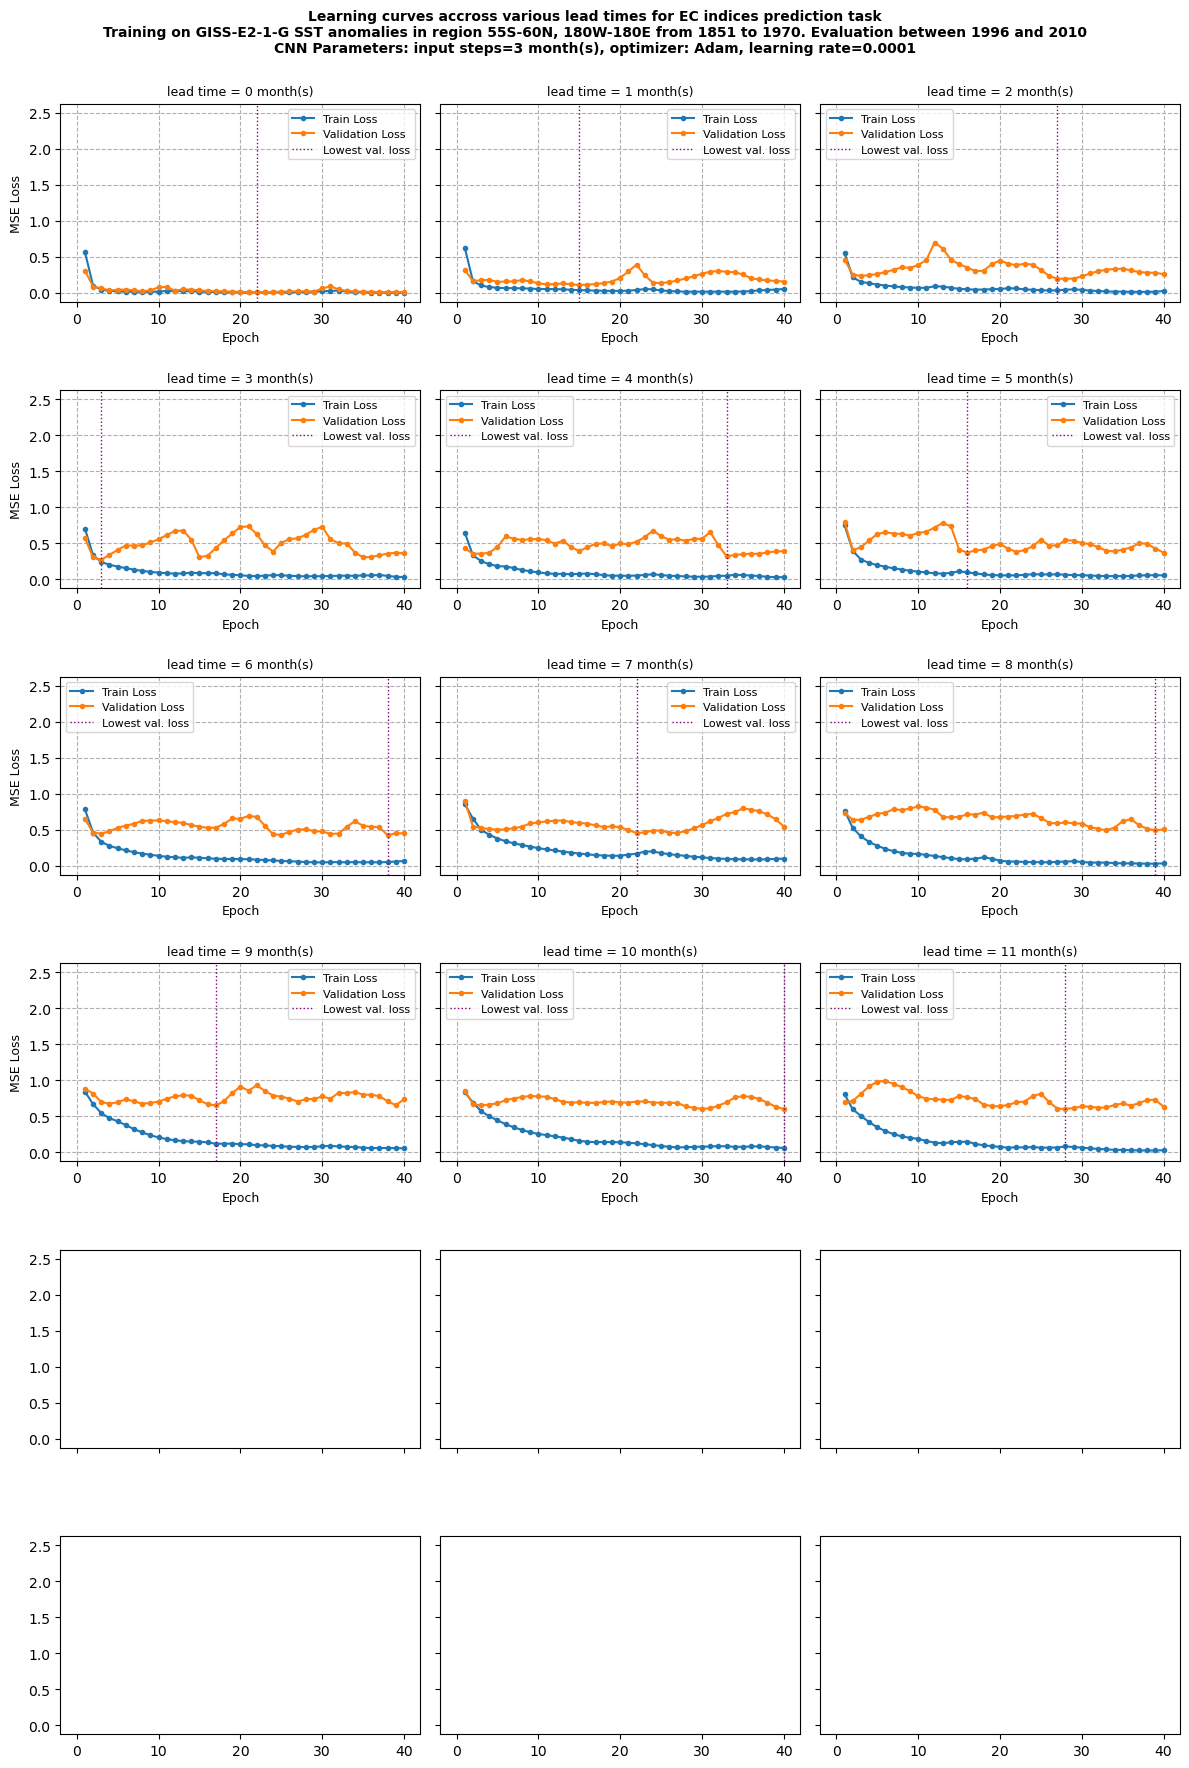

In [50]:
if mode == "training":
    # for target in TARGETS:
    fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(12, 18), sharex=True, sharey=True)
    
    # Iterate over the linear regression models' results and their respective axes
    for i, (cnn_dict, ax) in enumerate(zip(cnn_results[target], axs.flat)):
        
        # Plot Training and Validation losses
        ax.plot(range(1, len(cnn_dict["train_losses"])+1), cnn_dict["train_losses"], label='Train Loss', marker='o', markersize=3)
        ax.plot(range(1, len(cnn_dict["val_losses"])+1), cnn_dict["val_losses"], label='Validation Loss', marker='o', markersize=3)
        # ax.set_ylim(0, None)
        ax.axvline(x=cnn_dict["best_epoch"], color='purple', linestyle='dotted', linewidth=1, label=f'Lowest val. loss')
        ax.set_title(f"lead time = {cnn_dict['lead_time']} month(s)", fontsize=9)
        ax.tick_params(axis='x', which='both', labelbottom=True) # ensure the x-axis labels are visible for each subplot
        ax.grid(linestyle='dashed')
        ax.legend(fontsize=8)
        # ax.set_xticks(np.arange(1, NUM_EPOCHS), minor=True)
        ax.set_xlabel(f'Epoch', fontsize=9)
        if i % 3 == 0:
            ax.set_ylabel(f'MSE Loss', fontsize=9)

        # add 5% margins around the x limits
        x_lower_limit = 0
        x_upper_limit = NUM_EPOCHS            
        x_lower_bound = x_lower_limit - 0.05 * x_upper_limit  
        x_upper_bound = x_upper_limit + 0.05 * x_upper_limit  
        ax.set_xlim(x_lower_bound, x_upper_bound)


        
        # add 5% margins around the y limits
        y_lower_limit = 0
        y_upper_limit = 2.5            
        y_lower_bound = y_lower_limit - 0.05 * y_upper_limit  
        y_upper_bound = y_upper_limit + 0.05 * y_upper_limit  
        ax.set_ylim(y_lower_bound, y_upper_bound)

        # handles, labels = ax.get_legend_handles_labels()
        
    # fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.2, 0.88))
    fig.suptitle(f'Learning curves accross various lead times for EC indices prediction task\n'
                 # f'CNN trained on {cnn_dict['source_id']} data from {train_start_year} to {train_end_year} with {cnn_dict['num_input_time_steps']} time-steps per input to predict {cnn_dict['target']} Index\n'
                 f'{cnn_subtitle}',
                 fontsize=10, fontweight="bold")
    
    # fig.text(0.5, 0.0, 'Epoch', ha='center', va='center', fontsize=9, fontweight="bold")
    # fig.text(0.00, 0.5,  'MSE Loss', ha='center', va='center', rotation='vertical', fontsize=9, fontweight="bold")
    plt.tight_layout(h_pad=2, w_pad=None, rect=[0, 0, 1, 0.98]) # (left, bottom, right, top), default: (0, 0, 1, 1)

    if SAVE_PLOTS_TO_DISK == True:
        filename = f"plot_learning_curves_{cnn_dict['experiment_name']}.jpg"
        fig.savefig(IMG_FOLDER+filename, dpi=300, bbox_inches='tight')
        print(f"Saved {filename} to disk")
    
    plt.show()

### Plot Predicted vs True Index

In [51]:
# get maximum abs value and use it for y_min and y_max
for target in TARGETS:
    for cnn_dict in cnn_results[target]:
        v_min, v_max = np.inf, -np.inf
        v_min = min(v_min, cnn_dict['predictions'].min(), cnn_dict['y_test'].min())
        v_max = max(v_max, cnn_dict['predictions'].max(), cnn_dict['y_test'].max())
        abs_v_max = max(abs(v_min), abs(v_max))

# add 1 to get a little margin
abs_v_max = abs_v_max + 1
abs_v_max

3.602930784225464

target: E
Saved plot_pred_true_timeseries_e_index_Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead08_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00.jpg to disk


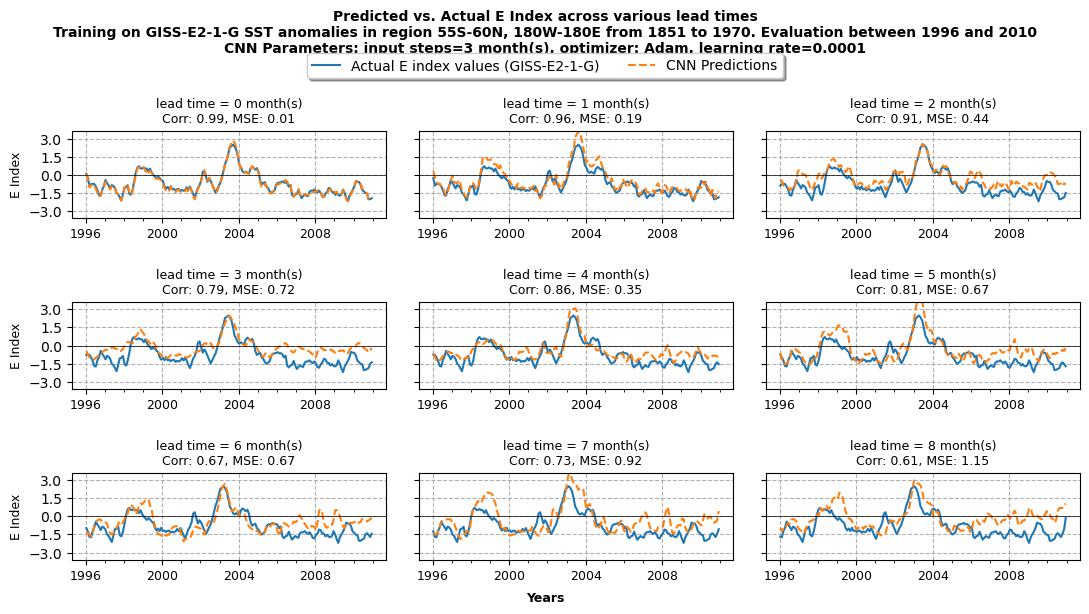







target: C
Saved plot_pred_true_timeseries_e_index_Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead08_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00.jpg to disk


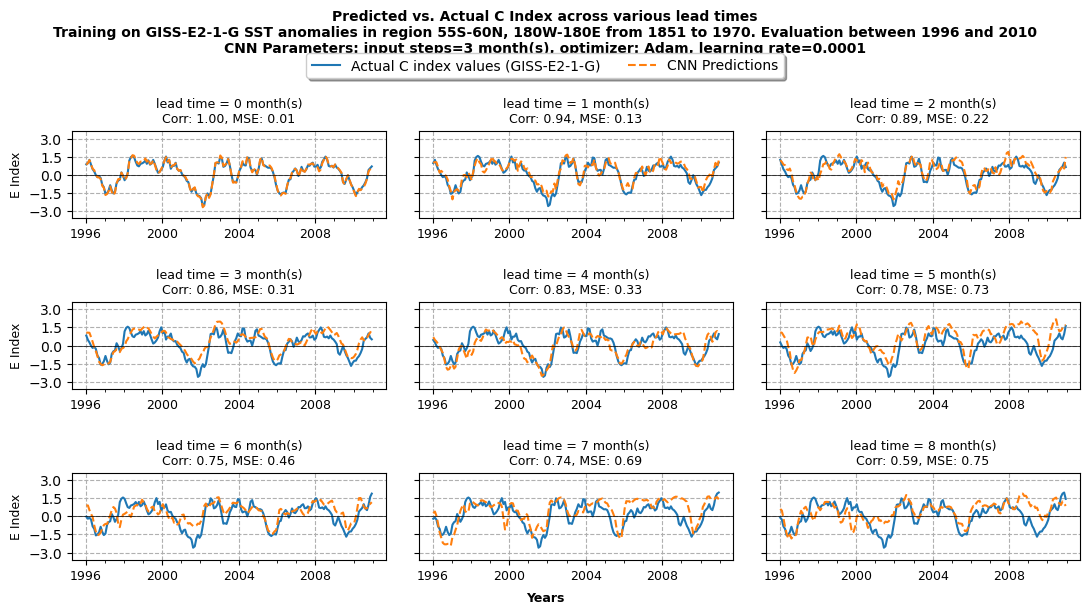

In [52]:
ROWS_TO_SHOW = 3
for target in TARGETS:
    print(f"target: {target}")
    fig, axs = plt.subplots(nrows=ROWS_TO_SHOW, ncols=3, figsize=(11, ROWS_TO_SHOW*2), sharex=True, sharey=True)
    
    # Iterate over the linear regression models' results and their respective axes
    for i, (cnn_dict, ax) in enumerate(zip(cnn_results[target], axs.flat)):
        y_train_target_datetime = cnn_dict['y_test_target_datetime']
        predictions = cnn_dict['predictions']
        y_test = cnn_dict['y_test']
    
        # Evaluate the model on the validation data
        corr, _ = scipy.stats.pearsonr(predictions, y_test)
        mse = mean_squared_error(y_test, predictions)
        
        # Plot machine learning predictions and actual values on the same plot
        ax.plot(y_train_target_datetime, y_test, label=f'Actual {target} index values ({source_id})')
        ax.plot(y_train_target_datetime, predictions, '--', label='CNN Predictions')
    
        ax.set_ylim(-abs_v_max, abs_v_max)
        ax.yaxis.set_major_locator(MultipleLocator(1.5))  # Set y-ticks at every 1.5 increment
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax.xaxis.set_major_locator(mdates.YearLocator(base=4))  # base=2 for every other year    
        ax.xaxis.set_minor_locator(mdates.YearLocator(base=1))  # base=2 for every other year    
        ax.set_title(f"lead time = {cnn_dict['lead_time']} month(s)\nCorr: {corr:.2f}, MSE: {mse:.2f}", fontsize=9)
        ax.tick_params(axis='x', which='both', labelbottom=True, labelsize=9) # ensure the x-axis labels are visible for each subplot
        ax.grid(linestyle='dashed')
        
        if i % 3 == 0:
            ax.set_ylabel(f'E Index', fontsize=9)
    
        handles, labels = ax.get_legend_handles_labels()
        
    # fig.legend(handles, [labels[0], "CNN Predictions"], loc='upper center', bbox_to_anchor=(0.5, 0.959), ncol=2, shadow=True)
    fig.legend(handles, [labels[0], "CNN Predictions"], loc='upper center', bbox_to_anchor=(0.5, 0.919), ncol=2, shadow=True)
    fig.suptitle(f'Predicted vs. Actual {target} Index across various lead times\n'
                 f'{cnn_subtitle}'
                 # f'CNN trained on {source_id} data from {train_start_year} to {train_end_year} with {cnn_dict['num_input_time_steps']} time-steps per input'
                , fontsize=10, fontweight="bold")
    fig.text(0.5, 0.0, 'Years', ha='center', va='center', fontsize=9, fontweight="bold")
    # fig.text(0.00, 0.5,  f'{target.upper()}', ha='center', va='center', rotation='vertical', fontsize=9, fontweight="bold")
    fig.tight_layout(h_pad=2, w_pad=2, rect=[0, 0, 1, 0.96]) # (left, bottom, right, top), default: (0, 0, 1, 1)
    
    if SAVE_PLOTS_TO_DISK == True:
        filename = f"plot_pred_true_timeseries_e_index_{cnn_dict['experiment_name']}.jpg"
        fig.savefig(IMG_FOLDER+filename, dpi=300, bbox_inches='tight')
        print(f"Saved {filename} to disk")
        
    plt.show()
    print("\n\n\n===================================================================================================================================\n\n\n")

## Compare with other models

### Load corresponding results from PF, LR, RR

In [53]:
!ls $RESULTS_EC_PF_FOLDER

results_PF_GISS-E2-1-G_CIdx_Test1996-2010.pkl
results_PF_GISS-E2-1-G_EIdx_Test1996-2010.pkl


In [54]:
TARGETS

['E', 'C']

In [55]:
persist_model_results, lin_reg_results, ridge_reg_results = {}, {}, {}

for target in ['E', 'C']:
    print(f"Load model results for target {target}")
    search_term = f"{source_id}_{target}"
    print(search_term)
    
    # Load persistent forecast results as pickle file
    filename, filepath = find_file(RESULTS_EC_PF_FOLDER, search_term)
    with open(filepath, "rb") as file:
        persist_model_results[target] = pickle.load(file)
        print(f"• PF: {filepath}")
    
    search_term = (
        f"{source_id}_"
        f"{utils.add_cardinals_fname(MIN_LAT, MAX_LAT, MIN_LON, MAX_LON)}_"
        f"{target.capitalize()}Idx_")

    print(search_term)


        
    # Load Linear Regression results as pickle file
    filename, filepath = find_file(RESULTS_EC_LR_FOLDER, search_term)
    with open(filepath, "rb") as file:
        lin_reg_results[target] = pickle.load(file)
        print(f"• LR: {filepath}")
                        
    # Load Ridge Regression results as pickle file
    filename, filepath = find_file(RESULTS_EC_RR_FOLDER, search_term)
    with open(filepath, "rb") as file:
        ridge_reg_results[target] = pickle.load(file)
        print(f"• RR: {filepath}")


    search_term = (
        f"results_TelloCNN_"
        f"{source_id}_"
        f"{utils.add_cardinals_fname(MIN_LAT, MAX_LAT, MIN_LON, MAX_LON)}_"
        f"{target.capitalize()}Idx_")

    # Load CNN results as pickle file
    filename, filepath = find_file(RESULTS_EC_CNN_FOLDER, search_term)
    with open(filepath, "rb") as file:
        cnn_results[target] = pickle.load(file)
        print(f"• CNN: {filepath}")
    print()

Load model results for target E
GISS-E2-1-G_E
• PF: saved_results/ec/persistent_forecast/results_PF_GISS-E2-1-G_EIdx_Test1996-2010.pkl
GISS-E2-1-G_55S-60N-180W-180E_EIdx_
• LR: saved_results/ec/linear_regression/results_LR_GISS-E2-1-G_55S-60N-180W-180E_EIdx_Train1851-1970_Test1996-2010.pkl
• RR: saved_results/ec/ridge_regression/results_RR_GISS-E2-1-G_55S-60N-180W-180E_EIdx_Train1851-1970_Test1996-2010_Alpha8e+03.pkl
• CNN: saved_results/ec/cnn/results_TelloCNN_GISS-E2-1-G_55S-60N-180W-180E_EIdx_Train1851-1970_Test1996-2010_Win03_Adam_LR1e-04_WD0e+00_.pkl

Load model results for target C
GISS-E2-1-G_C
• PF: saved_results/ec/persistent_forecast/results_PF_GISS-E2-1-G_CIdx_Test1996-2010.pkl
GISS-E2-1-G_55S-60N-180W-180E_CIdx_
• LR: saved_results/ec/linear_regression/results_LR_GISS-E2-1-G_55S-60N-180W-180E_CIdx_Train1851-1970_Test1996-2010.pkl
• RR: saved_results/ec/ridge_regression/results_RR_GISS-E2-1-G_55S-60N-180W-180E_CIdx_Train1851-1970_Test1996-2010_Alpha8e+03.pkl
• CNN: saved_res

In [56]:
# extract correlations and mses
pf_correlations, lr_correlations, rr_correlations, cnn_correlations = {}, {}, {}, {}
pf_mses, lr_mses, rr_mses, cnn_mses = {}, {}, {}, {}

for target in ['E', 'C']:
    pf_correlations[target] = [pf_dict['corr'] for pf_dict in persist_model_results[target]]
    lr_correlations[target] = [lr_dict['corr'] for lr_dict in lin_reg_results[target]]
    rr_correlations[target] = [rr_dict['corr'] for rr_dict in ridge_reg_results[target]]
    cnn_correlations[target] = [cnn_dict['corr'] for cnn_dict in cnn_results[target]]

    pf_mses[target] = [pf_dict['mse'] for pf_dict in persist_model_results[target]]
    lr_mses[target] = [lr_dict['mse'] for lr_dict in lin_reg_results[target]]
    rr_mses[target] = [rr_dict['mse'] for rr_dict in ridge_reg_results[target]]
    cnn_mses[target] = [cnn_dict['mse'] for cnn_dict in cnn_results[target]]

In [57]:
# [cnn_dict['experiment_name'] for cnn_dict in cnn_results[target]]

cnn_results[target][-1]['experiment_name']

'Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead11_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00'

### Plot correlations and MSE across lead times

[0.9944039308433161, 0.9630196270052971, 0.9064948053003099, 0.7863923225220112, 0.8573642699890134, 0.8136892984918316, 0.6693027872665762, 0.7255383277777012, 0.6136371812632828, 0.5813396693372561, 0.5442617249264123, 0.5135233248793574]
Saved plot_corr_mse_Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead11_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00.jpg to disk


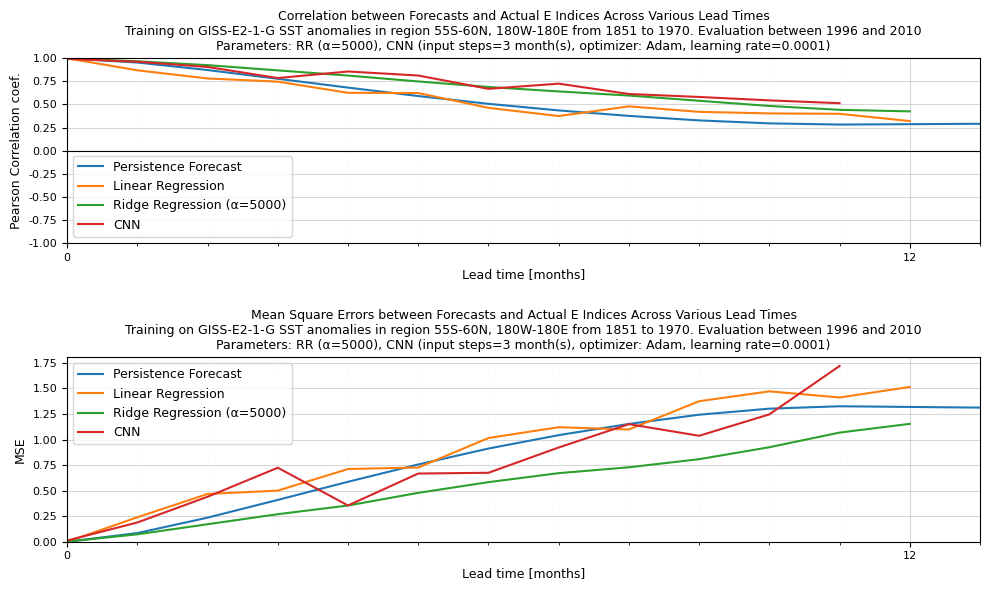







[0.9971906208663334, 0.9382408067997954, 0.8946569622706718, 0.8600051182572448, 0.8303739074820733, 0.7783143385120754, 0.7539525369522427, 0.7362442903577706, 0.5943897195642831, 0.6062322763188668, 0.5519401945341937, 0.5206713171856182]
Saved plot_corr_mse_Tello_CNN_GISS-E2-1-G_EC_Idx_Train1851-1970_Win03_Lead11_55S-60N-180W-180E_Adam_LR1e-04_WD0e+00.jpg to disk


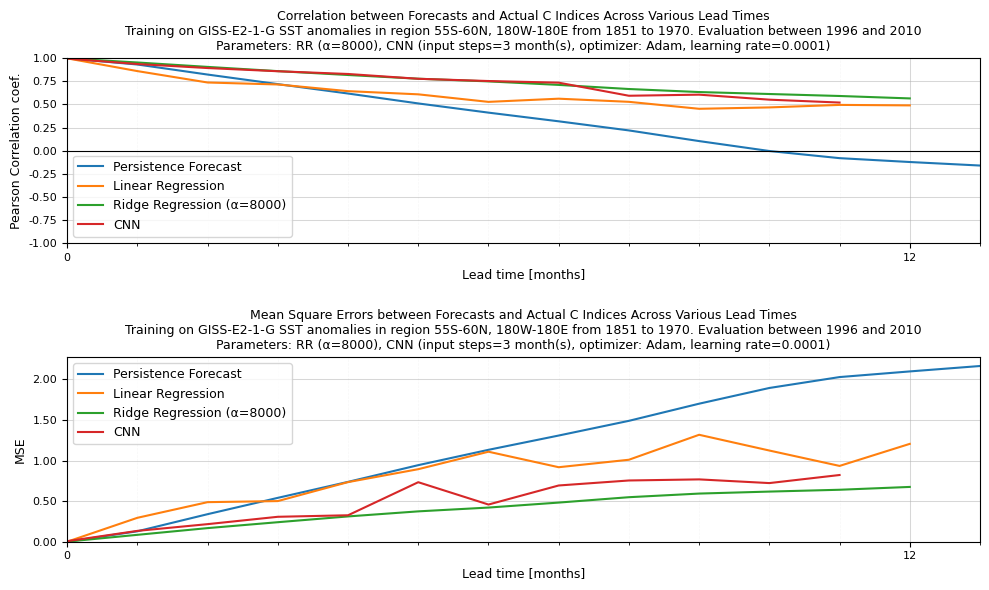

In [58]:
for target in ['E', 'C']:

    if target == 'E':
        alpha = 5000
    elif target == 'C':
        alpha = 8000
        
    coordinates = utils.add_cardinals_title(MIN_LAT, MAX_LAT, MIN_LON, MAX_LON)
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
    subtitle = (f'Training on {source_id} SST anomalies in region {coordinates} from {train_start_year} to {train_end_year}. Evaluation between {test_start_year} and {test_end_year}\n'
                f'Parameters: RR (α={alpha}), '
                f'CNN (input steps={INPUT_TIME_STEPS} month(s), optimizer: Adam, learning rate={LEARNING_RATE})')

    print(cnn_correlations[target])
    for i, ax in enumerate(axs.flat):
        if i == 0:
            ax.plot(range(0, len(pf_correlations[target])), pf_correlations[target], label="Persistence Forecast")        
            ax.plot(range(0, len(lr_correlations[target])), lr_correlations[target], label="Linear Regression")        
            ax.plot(range(0, len(rr_correlations[target])), rr_correlations[target], label=f"Ridge Regression (α={alpha})") 
            ax.plot(range(0, len(cnn_correlations[target])), cnn_correlations[target], label="CNN")        
            ax.set_ylabel('Pearson Correlation coef.', fontsize=9)
            ax.set_ylim(-1,1)
            ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
            ax.set_title(f'Correlation between Forecasts and Actual {target} Indices Across Various Lead Times\n{subtitle}', fontweight="normal", fontsize=9)
    
        if i == 1:
            ax.plot(range(0, len(pf_mses[target])), pf_mses[target], label="Persistence Forecast")        
            ax.plot(range(0, len(lr_mses[target])), lr_mses[target], label="Linear Regression")        
            ax.plot(range(0, len(rr_mses[target])), rr_mses[target], label=f"Ridge Regression (α={alpha})")     
            ax.plot(range(0, len(cnn_mses[target])), cnn_mses[target], label="CNN")        
            ax.set_ylabel('MSE', fontsize=9)
            ax.set_ylim(0,None)
            ax.set_title(f'Mean Square Errors between Forecasts and Actual {target} Indices Across Various Lead Times\n{subtitle}', fontweight="normal", fontsize=9)
    
            
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.set_xlabel('Lead time [months]', fontsize=9)
        # ax.set_xticks(range(0,MAX_LEAD_TIME))
        ax.set_xticks(np.arange(0, MAX_LEAD_TIME*5, 12))
    
        # Set the minor ticks to every month
        ax.set_xticks(np.arange(1, 49), minor=True)
        
        # Turn off minor tick labels
        ax.set_xticklabels([], minor=True)
    
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.margins(x=0)
    
        ax.grid(which='major', linewidth=0.75, alpha=0.5)
        ax.grid(which='minor', linestyle='--', linewidth=0.5, alpha=0.1)
    
        ax.legend(fontsize=9)
    
    fig.tight_layout(h_pad=2)
    
    if SAVE_PLOTS_TO_DISK == True:
        filename = f"plot_corr_mse_{cnn_results[target][-1]['experiment_name']}.jpg"
        fig.savefig(IMG_FOLDER+filename, dpi=300, bbox_inches='tight')
        print(f"Saved {filename} to disk")
    plt.show()
    print("\n\n\n\n\n")